In [1]:
# import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from scipy import signal
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES
import xgrid_utils
import pickle

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
# we have tw historical for awi-cm-1-1-lr and ssp245 for awi-cm-1-1-mr

cmip6_models = ['access-cm2',
                'bcc-csm2-mr', 'canesm5', 'cmcc-esm2',
                'fgoals-g3', 'inm-cm4-8',
                'inm-cm5-0', 'kace-1-0-g',
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
                'mri-esm2-0', 'noresm2-lm', 'taiesm1']

# cmip6_models = ['access-cm2',
#                 'canesm5', 'cmcc-esm2',
#                 'fgoals-g3', 'inm-cm4-8',
#                 'inm-cm5-0', 'kace-1-0-g',
#                 'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
#                 'mri-esm2-0', 'noresm2-lm', 'taiesm1']

cmip6_models_pr = ['access-cm2',
                'canesm5', 'cmcc-esm2',
                'fgoals-g3', 'inm-cm4-8',
                'inm-cm5-0', 'kace-1-0-g',
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
                'mri-esm2-0', 'noresm2-lm', 'taiesm1']
# cmip6_models = ['taiesm1']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})

cmip6_lat_sel = regridMesh_global.sel(lat=slice(-60,60)).lat
cmip6_lon_sel = regridMesh_global.sel(lat=slice(-60,60)).lon

# model = cmip6_models[7]

In [4]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirUtil = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/util'
dataDirLens = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/LENS/daily/atm'

In [5]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_60 = land_sea_mask.sel(latitude=slice(60,-60))
land_sea_mask_binary = land_sea_mask > 0.1

In [6]:
# Load the DataArray containing the months of annual maximum temperature
annual_max_months_da_tx = xr.open_dataarray("txx_months_1981_2021.nc")
annual_max_months_da_tx.load();
annual_max_months_da_tw = xr.open_dataarray("tw_months_1981_2021.nc")
annual_max_months_da_tw.load();
annual_max_months_da_tx = annual_max_months_da_tx.rename({'latitude':'lat', 'longitude':'lon'})

In [7]:
recalc = False

In [8]:

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, combine='nested', concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)

tx_tw_corr_full = tx_tw_corr_full.sel(latitude=slice(60,-60))
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')
tx_tw_corr_ts = xgrid_utils.calc_spatial_mean(tx_tw_corr_full)

In [9]:
with open('era5_huss_on_txx_per_rtet.dat', 'rb') as f:
    era5_huss_on_txx_per_rtet = pickle.load(f)
with open('era5_huss_on_tww_per_rtet.dat', 'rb') as f:
    era5_huss_on_tww_per_rtet = pickle.load(f)
    
with open('era5_tw_on_txx_per_rtet.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet = pickle.load(f)
with open('era5_tw_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_txx_per_rtet_r2 = pickle.load(f)

with open('era5_tw_on_txx_minus_tw_on_tww_per_rtet.dat', 'rb') as f:
    era5_tw_on_txx_minus_tw_on_tww_per_rtet = pickle.load(f)
with open('era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2 = pickle.load(f)
    
with open('era5_tx_on_txx_per_rtet.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet = pickle.load(f)
with open('era5_tx_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_txx_per_rtet_r2 = pickle.load(f)
    
with open('era5_tw_on_tww_per_rtet.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet = pickle.load(f)
with open('era5_tw_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tw_on_tww_per_rtet_r2 = pickle.load(f)
    
with open('era5_tx_on_tww_per_rtet.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet = pickle.load(f)
with open('era5_tx_on_tww_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_tww_per_rtet_r2 = pickle.load(f)
    
with open('era5_tx_on_tww_minus_tx_on_txx_per_rtet.dat', 'rb') as f:
    era5_tx_on_tww_minus_tx_on_txx_per_rtet = pickle.load(f)
with open('era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2.dat', 'rb') as f:
    era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2 = pickle.load(f)

    
    
era5_huss_on_txx_per_rtet_da = xr.DataArray(
    era5_huss_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_huss_on_txx_per_rtet_da.latitude.values, 'lon':era5_huss_on_txx_per_rtet_da.longitude.values, 'data':era5_huss_on_txx_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_huss_on_txx_per_rtet_da_regrid = regridder(era5_huss_on_txx_per_rtet_da)
era5_huss_on_txx_per_rtet_da_regrid = era5_huss_on_txx_per_rtet_da_regrid.reindex(lat=era5_huss_on_txx_per_rtet_da_regrid.lat[::-1])


era5_huss_on_tww_per_rtet_da = xr.DataArray(
    era5_huss_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_huss_on_tww_per_rtet_da.latitude.values, 'lon':era5_huss_on_tww_per_rtet_da.longitude.values, 'data':era5_huss_on_tww_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_huss_on_tww_per_rtet_da_regrid = regridder(era5_huss_on_tww_per_rtet_da)
era5_huss_on_tww_per_rtet_da_regrid = era5_huss_on_tww_per_rtet_da_regrid.reindex(lat=era5_huss_on_tww_per_rtet_da_regrid.lat[::-1])


# TW ON TWW
era5_tw_on_tww_per_rtet_da = xr.DataArray(
    era5_tw_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tw_on_tww_per_rtet_da.latitude.values, 'lon':era5_tw_on_tww_per_rtet_da.longitude.values, 'data':era5_tw_on_tww_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_tww_per_rtet_da_regrid = regridder(era5_tw_on_tww_per_rtet_da)
era5_tw_on_tww_per_rtet_da_regrid = era5_tw_on_tww_per_rtet_da_regrid.reindex(lat=era5_tw_on_tww_per_rtet_da_regrid.lat[::-1])


era5_tw_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tw_on_tww_per_rtet_da.latitude.values, 'lon':era5_tw_on_tww_per_rtet_da.longitude.values, 'data':era5_tw_on_tww_per_rtet_r2_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_tww_per_rtet_da_r2_regrid = regridder(era5_tw_on_tww_per_rtet_r2_da)
era5_tw_on_tww_per_rtet_da_r2_regrid = era5_tw_on_tww_per_rtet_da_r2_regrid.reindex(lat=era5_tw_on_tww_per_rtet_da_r2_regrid.lat[::-1])






# TW ON TXX MINUS TW ON TWW
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da = xr.DataArray(
    era5_tw_on_txx_minus_tw_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tw_on_txx_minus_tw_on_tww_per_rtet_da.latitude.values, 'lon':era5_tw_on_txx_minus_tw_on_tww_per_rtet_da.longitude.values, 'data':era5_tw_on_txx_minus_tw_on_tww_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid = regridder(era5_tw_on_txx_minus_tw_on_tww_per_rtet_da)
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid = era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid.reindex(lat=era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid.lat[::-1])


era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tw_on_txx_minus_tw_on_tww_per_rtet_da.latitude.values, 'lon':era5_tw_on_txx_minus_tw_on_tww_per_rtet_da.longitude.values, 'data':era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_r2_regrid = regridder(era5_tw_on_txx_minus_tw_on_tww_per_rtet_r2_da)
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_r2_regrid = era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_r2_regrid.reindex(lat=era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_r2_regrid.lat[::-1])




# TX ON TWW MINUS TX ON TXX
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da = xr.DataArray(
    era5_tx_on_tww_minus_tx_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_on_tww_minus_tx_on_txx_per_rtet_da.latitude.values, 'lon':era5_tx_on_tww_minus_tx_on_txx_per_rtet_da.longitude.values, 'data':era5_tx_on_tww_minus_tx_on_txx_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid = regridder(era5_tx_on_tww_minus_tx_on_txx_per_rtet_da)
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid = era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid.reindex(lat=era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid.lat[::-1])


era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_on_tww_minus_tx_on_txx_per_rtet_da.latitude.values, 'lon':era5_tx_on_tww_minus_tx_on_txx_per_rtet_da.longitude.values, 'data':era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_r2_regrid = regridder(era5_tx_on_tww_minus_tx_on_txx_per_rtet_r2_da)
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_r2_regrid = era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_r2_regrid.reindex(lat=era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_r2_regrid.lat[::-1])





# TW ON TXX
era5_tw_on_txx_per_rtet_da = xr.DataArray(
    era5_tw_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tw_on_txx_per_rtet_da.latitude.values, 'lon':era5_tw_on_txx_per_rtet_da.longitude.values, 'data':era5_tw_on_txx_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_txx_per_rtet_da_regrid = regridder(era5_tw_on_txx_per_rtet_da)
era5_tw_on_txx_per_rtet_da_regrid = era5_tw_on_txx_per_rtet_da_regrid.reindex(lat=era5_tw_on_txx_per_rtet_da_regrid.lat[::-1])


era5_tw_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tw_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tw_on_txx_per_rtet_da.latitude.values, 'lon':era5_tw_on_txx_per_rtet_da.longitude.values, 'data':era5_tw_on_txx_per_rtet_r2_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_txx_per_rtet_r2_da_regrid = regridder(era5_tw_on_txx_per_rtet_r2_da)
era5_tw_on_txx_per_rtet_r2_da_regrid = era5_tw_on_txx_per_rtet_r2_da_regrid.reindex(lat=era5_tw_on_txx_per_rtet_r2_da_regrid.lat[::-1])



# TX ON TXX
era5_tx_on_txx_per_rtet_da = xr.DataArray(
    era5_tx_on_txx_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_on_txx_per_rtet_da.latitude.values, 'lon':era5_tx_on_txx_per_rtet_da.longitude.values, 'data':era5_tx_on_txx_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_txx_per_rtet_da_regrid = regridder(era5_tx_on_txx_per_rtet_da)
era5_tx_on_txx_per_rtet_da_regrid = era5_tx_on_txx_per_rtet_da_regrid.reindex(lat=era5_tx_on_txx_per_rtet_da_regrid.lat[::-1])

era5_tx_on_txx_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_txx_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_on_txx_per_rtet_da.latitude.values, 'lon':era5_tx_on_txx_per_rtet_da.longitude.values, 'data':era5_tx_on_txx_per_rtet_r2_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_txx_per_rtet_r2_da_regrid = regridder(era5_tx_on_txx_per_rtet_r2_da)
era5_tx_on_txx_per_rtet_r2_da_regrid = era5_tx_on_txx_per_rtet_r2_da_regrid.reindex(lat=era5_tx_on_txx_per_rtet_r2_da_regrid.lat[::-1])






# TX ON TWW
era5_tx_on_tww_per_rtet_da = xr.DataArray(
    era5_tx_on_tww_per_rtet,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_on_tww_per_rtet_da.latitude.values, 'lon':era5_tx_on_tww_per_rtet_da.longitude.values, 'data':era5_tx_on_tww_per_rtet_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_tww_per_rtet_da_regrid = regridder(era5_tx_on_tww_per_rtet_da)
era5_tx_on_tww_per_rtet_da_regrid = era5_tx_on_tww_per_rtet_da_regrid.reindex(lat=era5_tx_on_tww_per_rtet_da_regrid.lat[::-1])



era5_tx_on_tww_per_rtet_r2_da = xr.DataArray(
    era5_tx_on_tww_per_rtet_r2,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_on_tww_per_rtet_da.latitude.values, 'lon':era5_tx_on_tww_per_rtet_da.longitude.values, 'data':era5_tx_on_tww_per_rtet_r2_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_tww_per_rtet_r2_da_regrid = regridder(era5_tx_on_tww_per_rtet_r2_da)
era5_tx_on_tww_per_rtet_r2_da_regrid = era5_tx_on_tww_per_rtet_r2_da_regrid.reindex(lat=era5_tx_on_tww_per_rtet_r2_da_regrid.lat[::-1])


    

Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite 

In [10]:
era5_tx_on_tx_ts = xr.open_dataset('intermediate/tx_on_tx_ts.nc')
era5_tw_on_tx_ts = xr.open_dataset('intermediate/tw_on_tx_ts.nc')
era5_tw_on_tw_ts = xr.open_dataset('intermediate/tw_on_tw_ts.nc')
era5_tx_on_tw_ts = xr.open_dataset('intermediate/tx_on_tw_ts.nc')

tw_on_tx_trend = xr.open_dataset('era5_tw_on_warm_season_tx_trends_by_decile_new.nc')
tw_on_tx_trend.load()
tw_on_tx_trend = tw_on_tx_trend.sel(latitude=slice(60,-60))

tx_on_tw_trend = xr.open_dataset('era5_tx_on_warm_season_tw_trends_by_decile_new.nc')
tx_on_tw_trend.load()
tx_on_tw_trend = tx_on_tw_trend.sel(latitude=slice(60,-60))

tw_on_tw_trend = xr.open_dataset('era5_tw_warm_season_trends_by_decile_new.nc')
tw_on_tw_trend.load()
tw_on_tw_trend = tw_on_tw_trend.sel(latitude=slice(60,-60))

tx_on_tx_trend = xr.open_dataset('era5_tx_warm_season_trends_by_decile_new.nc')
tx_on_tx_trend.load()
tx_on_tx_trend = tx_on_tx_trend.sel(latitude=slice(60,-60))

era5_huss_on_txx_trend = xr.open_dataset('era5_huss_on_txx_trends.nc')
era5_huss_on_txx_trend.load()
era5_huss_on_txx_trend['huss_on_txx_trend'] = era5_huss_on_txx_trend['huss_on_txx_trend'].sel(latitude=slice(60,-60))
era5_huss_on_txx_trend = era5_huss_on_txx_trend.rename({'latitude':'lat', 'longitude':'lon'})

era5_huss_on_tww_trend = xr.open_dataset('era5_huss_on_tww_trends.nc')
era5_huss_on_tww_trend.load()
era5_huss_on_tww_trend['huss_on_tww_trend'] = era5_huss_on_tww_trend['huss_on_tww_trend'].sel(latitude=slice(60,-60))
era5_huss_on_tww_trend = era5_huss_on_tww_trend.rename({'latitude':'lat', 'longitude':'lon'})

huss_on_tx_season_trend = xr.open_dataset('era5_huss_on_tx_season_trends.nc')
huss_on_tx_season_trend.load()
huss_on_tx_season_trend['huss_on_tx_season_trend'] = huss_on_tx_season_trend['huss_on_tx_season_trend'].sel(latitude=slice(60,-60))
huss_on_tx_season_trend = huss_on_tx_season_trend.rename({'latitude':'lat', 'longitude':'lon'})

era5_evap_on_txx_trend = xr.open_dataset('era5_evap_on_txx_trends.nc')
era5_evap_on_txx_trend.load()
era5_evap_on_txx_trend['evap_on_txx_trend'] = era5_evap_on_txx_trend['evap_on_txx_trend'].sel(latitude=slice(60,-60))
era5_evap_on_txx_trend = era5_evap_on_txx_trend.rename({'latitude':'lat', 'longitude':'lon'})

regridder = xe.Regridder(huss_on_tx_season_trend['huss_on_tx_season_trend'], 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
huss_on_tx_season_trend_regrid = np.flipud(regridder(huss_on_tx_season_trend['huss_on_tx_season_trend']));

regridder = xe.Regridder(era5_huss_on_txx_trend['huss_on_txx_trend'], 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=True)
era5_huss_on_txx_trend_regrid = np.flipud(regridder(era5_huss_on_txx_trend['huss_on_txx_trend']))

regridder = xe.Regridder(era5_huss_on_tww_trend['huss_on_tww_trend'], 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=True)
era5_huss_on_tww_trend_regrid = np.flipud(regridder(era5_huss_on_tww_trend['huss_on_tww_trend']))

regridder = xe.Regridder(era5_huss_on_tww_trend['huss_on_tww_trend'], 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=True)
era5_huss_on_tww_trend_regrid = np.flipud(regridder(era5_huss_on_tww_trend['huss_on_tww_trend']))


Overwrite existing file: bilinear_721x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Reuse existing file: bilinear_721x1440_81x240.nc
Reuse existing file: bilinear_721x1440_81x240.nc
Reuse existing file: bilinear_721x1440_81x240.nc


In [11]:
x = np.arange(era5_tx_on_tw_ts.mx2t[:,-1].shape[0])
era5_tx_tw_minus_tx_tx = (era5_tx_on_tw_ts.mx2t[:,-1])-era5_tx_on_tx_ts.mx2t[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tx_tw_minus_tx_tx.values,X).fit()
era5_tx_tw_vs_tx_tx_trend = mdl.params[1]*10
era5_tx_tw_vs_tx_tx_pval = mdl.pvalues[1]

era5_tw_tx_minus_tw_tw = (era5_tw_on_tx_ts.tw[:,-1])-era5_tw_on_tw_ts.tw[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tw_tx_minus_tw_tw.values,X).fit()
era5_tw_tx_vs_tw_tw_trend = mdl.params[1]*10
era5_tw_tx_vs_tw_tw_pval = mdl.pvalues[1]

In [30]:
# # load bootstrapped trends
# era5_r_tx_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
# era5_r_tx_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
# era5_r_tx_tw_vs_tw_on_tx_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
# era5_r_tx_tw_vs_tw_on_tx_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
# era5_r_tx_tw_vs_tx_on_tw_slope = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)
# era5_r_tx_tw_vs_tx_on_tw_int = np.full([tx_tw_corr_full.tx_tw_corr.shape[1], tx_tw_corr_full.tx_tw_corr.shape[2], 100], np.nan)

# lat_skip = 20
# for d in range(24):
#     with open(f'era5_r_tx_tw_slope_bootstrap_100_decile{d}_2_26_4pm.dat', 'rb') as f:
#         cur_era5_r_tx_tw_slice = pickle.load(f)
#         era5_r_tx_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_slope'][0:20,:,:]
#         era5_r_tx_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_int'][0:20,:,:]

#         era5_r_tx_tw_vs_tw_on_tx_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_slope'][0:20,:,:]
#         era5_r_tx_tw_vs_tw_on_tx_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tw_on_tx_int'][0:20,:,:]

#         era5_r_tx_tw_vs_tx_on_tw_slope[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_slope'][0:20,:,:]
#         era5_r_tx_tw_vs_tx_on_tw_int[(d*lat_skip):(d*lat_skip+lat_skip), :, :] = cur_era5_r_tx_tw_slice['r_tx_tw_vs_tx_on_tw_int'][0:20,:,:]

In [12]:
obs_slope = 0
nn = np.where((~np.isnan(tx_tw_corr_ts.tx_tw_corr.values)))[0]
X = sm.add_constant(range(nn.size))
mdl = sm.OLS(tx_tw_corr_ts.tx_tw_corr.values[nn], X).fit()
obs_slope = mdl.params[1]*10
obs_pval = mdl.pvalues[1]

In [13]:
cmip6_hist_corr_spatial = []
corr_ts = []
corr_ts_slopes = []
corr_ts_pvals = []

for model in cmip6_models:
    print(f"loading {model}")
    
    cur_tx_tw_corr = xr.open_dataset('tx_tw_corr_1981_2100_ssp245_%s.nc'%model)
    cur_tx_tw_corr.load()
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'lat':'latitude', 'lon':'longitude'})
    cur_corr_ts = xgrid_utils.calc_spatial_mean(cur_tx_tw_corr.tx_tw_corr)
#     cur_corr_ts = cur_tx_tw_corr.tx_tw_corr.mean(dim=['lat', 'lon']).values
    corr_ts.append(cur_corr_ts.values)
    
    nn = np.where((~np.isnan(cur_corr_ts)))[0]
    X = sm.add_constant(cur_tx_tw_corr.year.values[nn])
    mdl = sm.OLS(cur_corr_ts[nn].values, X).fit()
    corr_ts_slopes.append(mdl.params[1]*10)
    corr_ts_pvals.append(mdl.pvalues[1])
    
    # Assign the model as a coordinate in the current data array
    cur_tx_tw_corr = cur_tx_tw_corr.assign_coords(model=model)

    # Add the current data array to the list
    cmip6_hist_corr_spatial.append(cur_tx_tw_corr)
    

# Concatenate along the new dimension 'model'
cmip6_hist_corr_spatial = xr.concat(cmip6_hist_corr_spatial, dim='model')
cmip6_hist_corr_spatial = cmip6_hist_corr_spatial.reindex(latitude=cmip6_hist_corr_spatial.latitude[::-1])
cmip6_hist_corr_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial)
corr_ts = np.array(corr_ts)

loading access-cm2
loading bcc-csm2-mr
loading canesm5
loading cmcc-esm2
loading fgoals-g3
loading inm-cm4-8
loading inm-cm5-0
loading kace-1-0-g
loading mpi-esm1-2-hr
loading mpi-esm1-2-lr
loading mri-esm2-0
loading noresm2-lm
loading taiesm1


In [14]:
recalc = False

if recalc:
    cmip6_r_tx_tw_per_deg = np.full([len(cmip6_models), regridMesh_global.sel(lat=slice(-60,60)).lat.size, regridMesh_global.sel(lat=slice(-60,60)).lon.size], np.nan)
    for m in range(0,len(cmip6_models)):
        print(cmip6_models[m])
        gmt_annual = xr.concat([tx_hist[m],tx_fut[m]],dim='time').tasmax.sel(time=slice('1981','2021')).sel(lat=slice(-60,60)).resample(time='Y').mean()

        regridder = xe.Regridder(gmt_annual, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=True)
        gmt_annual_regrid = regridder(gmt_annual);
        gmt_annual_regrid.load()

        r_tx_tw = cmip6_hist_corr_spatial.tx_tw_corr[m,:,:,:].sel(year=slice('1981','2021'))
        r_tx_tw.load()

        
        print('looping')
        r_tx_tw_per_deg = np.full([r_tx_tw.latitude.size, r_tx_tw.longitude.size],np.nan)
        for xlat in range(r_tx_tw.latitude.size):
            for ylon in range(r_tx_tw.longitude.size):
                cur_r_tx_tw = r_tx_tw[:,xlat,ylon].values
                cur_gmt = gmt_annual_regrid[:,xlat,ylon].values
                nn = np.where((~np.isnan(cur_r_tx_tw)) & (~np.isnan(cur_gmt)))[0]

                if nn.size > 10:

                    cur_r_tx_tw_detrend = signal.detrend(cur_r_tx_tw[nn])
                    cur_gmt_detrend = signal.detrend(cur_gmt[nn])
                
                    X = sm.add_constant(cur_gmt_detrend)
                    mdl = sm.OLS(cur_r_tx_tw_detrend,X).fit()

                    r_tx_tw_per_deg[xlat,ylon] = mdl.params[1]
                    
        cmip6_r_tx_tw_per_deg[m,:,:] = r_tx_tw_per_deg
    
    with open('cmip6_r_tx_tw_per_deg.dat', 'wb') as f:
        pickle.dump(cmip6_r_tx_tw_per_deg, f)
else:
    with open('cmip6_r_tx_tw_per_deg.dat', 'rb') as f:
        cmip6_r_tx_tw_per_deg = pickle.load(f)

In [15]:
with open('era5_r_tx_tw_per_deg.dat', 'rb') as f:
    era5_r_tx_tw_per_deg = pickle.load(f)
with open('era5_r_tx_tw_per_gmt_deg.dat', 'rb') as f:
    era5_r_tx_tw_per_gmt_deg = pickle.load(f)

In [16]:
recalc = False

if recalc:
    # calc 
    year_range = np.arange(2010, 2100)
    cmip6_adj_rtxtw_chg = []
    cmip6_rtxtw_gmt_chg = []

    for m in range(0, len(cmip6_models)):
        print(cmip6_models[m])
        gmt_annual = xr.concat([tx_hist[m],tx_fut[m]],dim='time').tasmax.sel(time=slice('1981','2100')).sel(lat=slice(-60,60)).resample(time='Y').mean()
        gmt_annual_anom = gmt_annual - gmt_annual.sel(time=slice('1981', '2010')).mean(dim='time')
        gmt_annual_anom.load()

        gmt_annual_gmt = xgrid_utils.calc_spatial_mean(gmt_annual.rename({'lat':'latitude', 'lon':'longitude'}))
        gmt_annual_gmt_anom = gmt_annual_gmt - gmt_annual_gmt.sel(time=slice('1981', '2010')).mean(dim='time')
        gmt_annual_gmt_anom.load()

        regridder = xe.Regridder({'lat':land_sea_mask_60.latitude.values, 'lon':land_sea_mask_60.longitude.values, 'data':era5_r_tx_tw_per_deg}, {'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values}, 'bilinear', reuse_weights=False)
        era5_r_tx_tw_per_deg_regrid = regridder(era5_r_tx_tw_per_deg);

        regridder = xe.Regridder({'lat':land_sea_mask_60.latitude.values, 'lon':land_sea_mask_60.longitude.values, 'data':era5_r_tx_tw_per_gmt_deg}, {'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values}, 'bilinear', reuse_weights=False)
        era5_r_tx_tw_per_deg_gmt_regrid = regridder(era5_r_tx_tw_per_gmt_deg);

        cur_cmip6_adj_rtxtw_chg = np.full([year_range.size, era5_r_tx_tw_per_deg_regrid.shape[0], era5_r_tx_tw_per_deg_regrid.shape[1]], np.nan)
        cur_cmip6_rtxtw_gmt_chg = np.full([year_range.size, era5_r_tx_tw_per_deg_regrid.shape[0], era5_r_tx_tw_per_deg_regrid.shape[1]], np.nan)

        for y in range(2010, 2100):
            cur_temp_anom = gmt_annual_anom.sel(time=slice(f'{y}', f'{y+1}')).mean(dim='time')
            cur_gmt_anom = gmt_annual_gmt_anom.sel(time=slice(f'{y}', f'{y+1}')).mean(dim='time')

            for xlat in range(era5_r_tx_tw_per_deg_regrid.shape[0]):
                for ylon in range(era5_r_tx_tw_per_deg_regrid.shape[1]):
                    cur_cmip6_adj_rtxtw_chg[y-2010, xlat, ylon] = cur_temp_anom.values[xlat, ylon] * era5_r_tx_tw_per_deg_regrid[xlat, ylon]
                    cur_cmip6_rtxtw_gmt_chg[y-2010, xlat, ylon] = cur_gmt_anom.values * era5_r_tx_tw_per_deg_gmt_regrid[xlat, ylon]


        regridder = xe.Regridder({'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values, 'data':cur_cmip6_adj_rtxtw_chg}, {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
        cur_cmip6_adj_rtxtw_chg_regrid = regridder(cur_cmip6_adj_rtxtw_chg)

        cur_cmip6_adj_rtxtw_chg_regrid_da = xr.DataArray(
            data=cur_cmip6_adj_rtxtw_chg_regrid,  # Use your data array here
            dims=["time", "latitude", "longitude"],  # Specify the dimensions names
            coords={
                "time":year_range,
                "latitude": regridMesh_global.sel(lat=slice(-60,60)).lat.values,  # Latitude coordinates
                "longitude": regridMesh_global.sel(lat=slice(-60,60)).lon.values  # Longitude coordinates
            }
        )
        cur_cmip6_adj_rtxtw_chg_regrid_da = cur_cmip6_adj_rtxtw_chg_regrid_da.reindex(latitude=cur_cmip6_adj_rtxtw_chg_regrid_da.latitude[::-1])

        cmip6_adj_rtxtw_chg.append(cur_cmip6_adj_rtxtw_chg_regrid_da)



        regridder = xe.Regridder({'lat':gmt_annual.lat.values, 'lon':gmt_annual.lon.values, 'data':cur_cmip6_rtxtw_gmt_chg}, {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
        cur_cmip6_rtxtw_gmt_chg_regrid = regridder(cur_cmip6_rtxtw_gmt_chg)

        cur_cmip6_rtxtw_gmt_chg_regrid_da = xr.DataArray(
            data=cur_cmip6_rtxtw_gmt_chg_regrid,  # Use your data array here
            dims=["time", "latitude", "longitude"],  # Specify the dimensions names
            coords={
                "time":year_range,
                "latitude": regridMesh_global.sel(lat=slice(-60,60)).lat.values,  # Latitude coordinates
                "longitude": regridMesh_global.sel(lat=slice(-60,60)).lon.values  # Longitude coordinates
            }
        )
        cur_cmip6_rtxtw_gmt_chg_regrid_da = cur_cmip6_rtxtw_gmt_chg_regrid_da.reindex(latitude=cur_cmip6_rtxtw_gmt_chg_regrid_da.latitude[::-1])

        cmip6_rtxtw_gmt_chg.append(cur_cmip6_rtxtw_gmt_chg_regrid_da)

    with open('cmip6_rtxtw_chg.dat', 'wb') as f:
        pickle.dump(cmip6_adj_rtxtw_chg, f)
    with open('cmip6_rtxtw_gmt_chg.dat', 'wb') as f:
        pickle.dump(cmip6_rtxtw_gmt_chg, f)
else:
    with open('cmip6_rtxtw_chg.dat', 'rb') as f:
        cmip6_adj_rtxtw_chg = pickle.load(f)
    with open('cmip6_rtxtw_gmt_chg.dat', 'rb') as f:
        cmip6_rtxtw_gmt_chg = pickle.load(f)

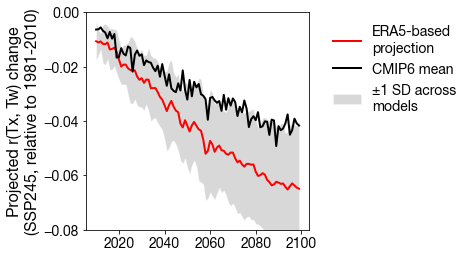

In [180]:
plt.figure(figsize=(4,4))
plt.ylim([-.08, 0])
cmip6_proj_2100_chg = []
ts = np.full([len(cmip6_models), 90], np.nan)

for m in range(len(cmip6_models)):
    cmip6_rtxtw_chg_da_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_adj_rtxtw_chg[m])    
    ts[m,:] = cmip6_rtxtw_chg_da_spatial_mean.values
    cmip6_proj_2100_chg.append(cmip6_rtxtw_chg_da_spatial_mean[-1])
    

plt.fill_between(np.arange(2010,2100), np.nanmean(ts, axis=0)-np.nanstd(ts, axis=0), 
                np.nanmean(ts, axis=0)+np.nanstd(ts, axis=0), color='gray', alpha=0.3, ec='white', label='±1 SD across\nmodels')
plt.plot(np.arange(2010,2100), np.nanmean(ts, axis=0), '-r', lw=2, label='ERA5-based\nprojection')
plt.plot(np.arange(2010,2100), \
         (cmip6_hist_corr_spatial_mean.tx_tw_corr - cmip6_hist_corr_spatial_mean.tx_tw_corr.sel(year=slice('1981', '2010')).mean(dim='year')).mean(dim='model').sel(year=slice('2010', '2099')).values, \
         '-k', lw=2, label='CMIP6 mean')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
plt.ylabel('Projected r(Tx, Tw) change\n(SSP245, relative to 1981-2010)')

cmip6_proj_2100_chg = np.array(cmip6_proj_2100_chg)
# plt.savefig('r(tx,tw)-in-cmip6-vs-era5-based-proj.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [20]:
cmip6_2100_chg = (cmip6_hist_corr_spatial_mean.tx_tw_corr - cmip6_hist_corr_spatial_mean.tx_tw_corr.sel(year=slice('1981', '2010')).mean(dim='year')).sel(year=slice('2010', '2099')).values[:,-1]

No handles with labels found to put in legend.


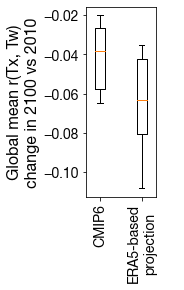

In [21]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-., 0])
plt.xlim([.5, 1.5])
plt.boxplot([cmip6_2100_chg, cmip6_proj_2100_chg], positions=[.7, 1.3])
plt.xticks([.7,1.3], rotation=90)
plt.gca().set_xticklabels(['CMIP6', 'ERA5-based\nprojection'])
plt.ylabel('Global mean r(Tx, Tw)\nchange in 2100 vs 2010')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-lens-era5-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [20]:
tx_on_tww_ds = []
tx_on_txx_ds = []
tw_on_tww_ds = []
tw_on_txx_ds = []

lh_on_txx_ds = []
huss_on_txx_ds = []
huss_on_tx_season_ds = []
huss_on_tww_ds = []
pr_on_tx_ds = []

# Loop through each model
for model in cmip6_models:
    # Construct the filename
    filename = f'output/cmip6/tx_on_tww_1981_2100_ssp245_{model}.nc'
    # Open the dataset and append to the list
    ds = xr.open_dataset(filename)
    tx_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tx_on_txx_1981_2100_ssp245_{model}.nc'
    ds = xr.open_dataset(filename)
    tx_on_txx_ds.append(ds)

    filename = f'output/cmip6/tw_on_tww_1981_2100_ssp245_{model}.nc'
    ds = xr.open_dataset(filename)
    tw_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tw_on_txx_1981_2100_ssp245_{model}.nc'
    print(model)
    ds = xr.open_dataset(filename)
    tw_on_txx_ds.append(ds)
    
    time_dim = pd.date_range("1981-01-01", "2100-12-31", freq="AS")
    filename = f'output/cmip6/lh_on_txx_1981_2100_ssp245_{model}.nc'
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        ds['time'] = time_dim
        lh_on_txx_ds.append(ds)
        
    time_dim = pd.date_range("1981-01-01", "2100-12-31", freq="AS")
    filename = f'output/cmip6/huss_on_txx_1981_2100_ssp245_{model}.nc'
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        ds['time'] = time_dim
        huss_on_txx_ds.append(ds)
        
    time_dim = pd.date_range("1981-01-01", "2100-12-31", freq="AS")
    filename = f'output/cmip6/huss_on_tx_warm_season_1981_2100_ssp245_{model}.nc'
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        ds['time'] = time_dim
        huss_on_tx_season_ds.append(ds)
        
    time_dim = pd.date_range("1981-01-01", "2100-12-31", freq="AS")
    filename = f'output/cmip6/huss_on_tww_1981_2100_ssp245_{model}.nc'
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        ds['time'] = time_dim
        huss_on_tww_ds.append(ds)
    else:
        huss_on_tww_ds.append(xr.Dataset())
        print('MISSING ', model)
        
    time_dim = pd.date_range("1981-01-01", "2100-12-31", freq="AS")
    filename = f'output/cmip6/pr_on_tx_1981_2100_ssp245_{model}.nc'
    if os.path.isfile(filename):
        ds = xr.open_dataset(filename)
        ds['time'] = time_dim
        pr_on_tx_ds.append(ds)


    
# # Concatenate all datasets along the 'model' dimension
tx_on_tww_ds = xr.concat(tx_on_tww_ds, dim='model')
tx_on_tww_ds['model'] = cmip6_models  
tx_on_tww_ds['time'] = np.arange(1981,2100+1)
tx_on_tww_ds = tx_on_tww_ds.rename({'__xarray_dataarray_variable__':'tx_on_tww'})
tx_on_tww_ds = tx_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})
tx_on_tww_ds = tx_on_tww_ds.reindex(latitude=tx_on_tww_ds.latitude[::-1])

tx_on_txx_ds = xr.concat(tx_on_txx_ds, dim='model')
tx_on_txx_ds['model'] = cmip6_models
tx_on_txx_ds['time'] = np.arange(1981,2100+1)
tx_on_txx_ds = tx_on_txx_ds.rename({'__xarray_dataarray_variable__':'tx_on_txx'})
tx_on_txx_ds = tx_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tx_on_txx_ds = tx_on_txx_ds.reindex(latitude=tx_on_txx_ds.latitude[::-1])

tw_on_tww_ds = xr.concat(tw_on_tww_ds, dim='model')
tw_on_tww_ds['model'] = cmip6_models  
tw_on_tww_ds['time'] = np.arange(1981,2100+1)
tw_on_tww_ds = tw_on_tww_ds.rename({'__xarray_dataarray_variable__':'tw_on_tww'})
tw_on_tww_ds = tw_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_tww_ds = tw_on_tww_ds.reindex(latitude=tw_on_tww_ds.latitude[::-1])

tw_on_txx_ds = xr.concat(tw_on_txx_ds, dim='model')
tw_on_txx_ds['model'] = cmip6_models  
tw_on_txx_ds['time'] = np.arange(1981,2100+1)
tw_on_txx_ds = tw_on_txx_ds.rename({'__xarray_dataarray_variable__':'tw_on_txx'})
tw_on_txx_ds = tw_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_txx_ds = tw_on_txx_ds.reindex(latitude=tw_on_txx_ds.latitude[::-1])



lh_on_txx_ds = xr.concat(lh_on_txx_ds, dim='model')
lh_on_txx_ds['model'] = cmip6_models  
lh_on_txx_ds = lh_on_txx_ds.rename({'__xarray_dataarray_variable__':'lh_on_txx'})
lh_on_txx_ds = lh_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
lh_on_txx_ds = lh_on_txx_ds.reindex(latitude=lh_on_txx_ds.latitude[::-1])

huss_on_txx_ds = xr.concat(huss_on_txx_ds, dim='model')
huss_on_txx_ds['model'] = cmip6_models  
huss_on_txx_ds = huss_on_txx_ds.rename({'__xarray_dataarray_variable__':'huss_on_txx'})
huss_on_txx_ds = huss_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
huss_on_txx_ds = huss_on_txx_ds.reindex(latitude=huss_on_txx_ds.latitude[::-1])

huss_on_tww_ds = xr.concat(huss_on_tww_ds, dim='model')
huss_on_tww_ds['model'] = cmip6_models  
huss_on_tww_ds = huss_on_tww_ds.rename({'__xarray_dataarray_variable__':'huss_on_tww'})
huss_on_tww_ds = huss_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})
huss_on_tww_ds = huss_on_tww_ds.reindex(latitude=huss_on_tww_ds.latitude[::-1])

pr_on_tx_ds = xr.concat(pr_on_tx_ds, dim='model', coords='minimal')
pr_on_tx_ds['model'] = cmip6_models_pr
pr_on_tx_ds = pr_on_tx_ds.rename({'lat':'latitude', 'lon':'longitude'})
pr_on_tx_ds = pr_on_tx_ds.reindex(latitude=pr_on_tx_ds.latitude[::-1])

access-cm2
bcc-csm2-mr
canesm5
cmcc-esm2
fgoals-g3
inm-cm4-8
inm-cm5-0
kace-1-0-g
mpi-esm1-2-hr
mpi-esm1-2-lr
mri-esm2-0
noresm2-lm
taiesm1


In [21]:
tw_on_txx_minus_tw_on_tww_ds = tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww
tx_on_tww_minus_tx_on_txx_ds = tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


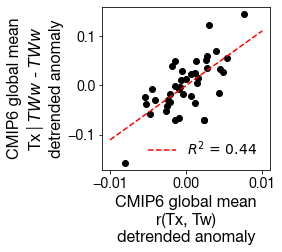

In [98]:
plt.figure(figsize=(3,3))

x_var = signal.detrend(cmip6_hist_corr_spatial_mean.tx_tw_corr.sel(year=slice('1981','2021')).mean(dim='model').values)
y_var = signal.detrend(xgrid_utils.calc_spatial_mean((tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx).sel(time=slice('1981','2021'))).mean(dim='model').values)

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl_tx_on_tww_minus_tww_per_rtet = sm.OLS(y_var[nn], X).fit()

x1 = -.01
x2 = 0.01

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl_tx_on_tww_minus_tww_per_rtet.params[0]+x1*mdl_tx_on_tww_minus_tww_per_rtet.params[1], mdl_tx_on_tww_minus_tww_per_rtet.params[0]+x2*mdl_tx_on_tww_minus_tww_per_rtet.params[1]], '--r', label='$R^2$ = %.2f'%mdl_tx_on_tww_minus_tww_per_rtet.rsquared)
plt.xlabel('CMIP6 global mean\nr(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('CMIP6 global mean\nTx | $TWw$ - $TWw$\ndetrended anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-tx|tw100-tx100.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

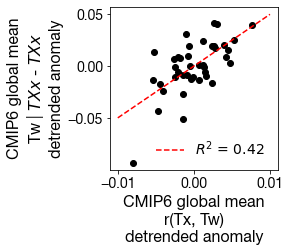

In [51]:
plt.figure(figsize=(3,3))

x_var = signal.detrend(cmip6_hist_corr_spatial_mean.tx_tw_corr.sel(year=slice('1981','2021')).mean(dim='model').values)
y_var = signal.detrend(xgrid_utils.calc_spatial_mean((tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww).sel(time=slice('1981','2021'))).mean(dim='model').values)

nn = np.where((~np.isnan(x_var)) & (~np.isnan(y_var)))[0]
X = sm.add_constant(x_var[nn])
mdl = sm.OLS(y_var[nn], X).fit()

x1 = -.01
x2 = 0.01

plt.scatter(x_var, y_var, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', label='$R^2$ = %.2f'%mdl.rsquared)
plt.xlabel('CMIP6 global mean\nr(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('CMIP6 global mean\nTw | $TXx$ - $TXx$\ndetrended anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

# plt.savefig('r(tx,tw)-tx|tw100-tx100.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [22]:
recalc = False

cmip6_huss_on_txx_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)
cmip6_huss_on_tww_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)
cmip6_tw_on_tww_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)
cmip6_tx_on_tww_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)
cmip6_tx_on_tww_minus_tx_on_txx_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)
cmip6_tw_on_txx_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)
cmip6_tw_on_txx_minus_tw_on_tww_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)
cmip6_tx_on_txx_per_rtet = np.full([len(cmip6_models), huss_on_txx_ds.latitude.size, huss_on_txx_ds.longitude.size], np.nan)

for m in range(len(cmip6_models)):
    print(cmip6_models[m])
    cur_huss_on_tww_ds = huss_on_tww_ds.huss_on_tww[m,:,:,:].sel(time=slice('1981', '2021'))
    cur_huss_on_txx_ds = huss_on_txx_ds.huss_on_txx[m,:,:,:].sel(time=slice('1981', '2021'))
    cur_tw_on_txx_ds = tw_on_txx_ds.tw_on_txx[m,:,:,:].sel(time=slice('1981', '2021'))
    cur_tw_on_tww_ds = tw_on_tww_ds.tw_on_tww[m,:,:,:].sel(time=slice('1981', '2021'))
    cur_tx_on_tww_ds = tx_on_tww_ds.tx_on_tww[m,:,:,:].sel(time=slice('1981', '2021'))
    cur_tx_on_txx_ds = tx_on_txx_ds.tx_on_txx[m,:,:,:].sel(time=slice('1981', '2021'))
    
    cur_tx_on_tww_minus_tx_on_txx_ds = cur_tx_on_tww_ds - cur_tx_on_txx_ds
    cur_tw_on_txx_minus_tw_on_tww_ds = cur_tw_on_txx_ds - cur_tw_on_tww_ds
    
    cur_r_tx_tw_ds = cmip6_hist_corr_spatial.tx_tw_corr[m,:,:,:].sel(year=slice('1981', '2021'))
    
    for xlat in range(huss_on_txx_ds.latitude.size):
        for ylon in range(huss_on_txx_ds.longitude.size):

            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_huss_on_txx_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 35:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_huss_on_txx_per_rtet[m, xlat, ylon] = mdl.params[1]
                
                
            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_huss_on_tww_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 20:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_huss_on_tww_per_rtet[m, xlat, ylon] = mdl.params[1]
                
                
            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_tw_on_tww_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 20:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_tw_on_tww_per_rtet[m, xlat, ylon] = mdl.params[1]
                
                
            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_tx_on_tww_minus_tx_on_txx_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 20:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_tx_on_tww_minus_tx_on_txx_per_rtet[m, xlat, ylon] = mdl.params[1]
                
                
                
            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_tw_on_txx_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 20:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_tw_on_txx_per_rtet[m, xlat, ylon] = mdl.params[1]
            
            
            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_tw_on_txx_minus_tw_on_tww_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 20:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_tw_on_txx_minus_tw_on_tww_per_rtet[m, xlat, ylon] = mdl.params[1]
            
            
                
            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_tx_on_txx_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 20:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_tx_on_txx_per_rtet[m, xlat, ylon] = mdl.params[1]
                
                
                
            v1 = cur_r_tx_tw_ds.values[:,xlat,ylon]
            v2 = cur_tx_on_tww_ds.values[:,xlat, ylon]

            nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

            if nn.size > 20:
                v1 = signal.detrend(v1[nn])
                v2 = signal.detrend(v2[nn])

                X = sm.add_constant(v1)
                mdl = sm.OLS(v2, X).fit()

                cmip6_tx_on_tww_per_rtet[m, xlat, ylon] = mdl.params[1]





cmip6_huss_on_txx_per_rtet_da = xr.DataArray(
    cmip6_huss_on_txx_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_huss_on_txx_per_rtet_da = cmip6_huss_on_txx_per_rtet_da.reindex(latitude=cmip6_huss_on_txx_per_rtet_da.latitude[::-1])
cmip6_huss_on_txx_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_huss_on_txx_per_rtet_da)


cmip6_huss_on_tww_per_rtet_da = xr.DataArray(
    cmip6_huss_on_tww_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_huss_on_tww_per_rtet_da = cmip6_huss_on_tww_per_rtet_da.reindex(latitude=cmip6_huss_on_tww_per_rtet_da.latitude[::-1])
cmip6_huss_on_tww_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_huss_on_tww_per_rtet_da)


cmip6_tw_on_tww_per_rtet_da = xr.DataArray(
    cmip6_tw_on_tww_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tw_on_tww_per_rtet_da = cmip6_tw_on_tww_per_rtet_da.reindex(latitude=cmip6_tw_on_tww_per_rtet_da.latitude[::-1])
cmip6_tw_on_tww_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_tw_on_tww_per_rtet_da)


cmip6_tw_on_txx_per_rtet_da = xr.DataArray(
    cmip6_tw_on_txx_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tw_on_txx_per_rtet_da = cmip6_tw_on_txx_per_rtet_da.reindex(latitude=cmip6_tw_on_txx_per_rtet_da.latitude[::-1])
cmip6_tw_on_txx_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_tw_on_txx_per_rtet_da)


cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da = xr.DataArray(
    cmip6_tw_on_txx_minus_tw_on_tww_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da = cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da.reindex(latitude=cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da.latitude[::-1])
cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da)


cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da = xr.DataArray(
    cmip6_tx_on_tww_minus_tx_on_txx_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da = cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da.reindex(latitude=cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da.latitude[::-1])
cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da)


cmip6_tx_on_txx_per_rtet_da = xr.DataArray(
    cmip6_tx_on_txx_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tx_on_txx_per_rtet_da = cmip6_tx_on_txx_per_rtet_da.reindex(latitude=cmip6_tx_on_txx_per_rtet_da.latitude[::-1])
cmip6_tx_on_txx_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_tx_on_txx_per_rtet_da)



cmip6_tx_on_tww_per_rtet_da = xr.DataArray(
    cmip6_tx_on_tww_per_rtet,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tx_on_tww_per_rtet_da = cmip6_tx_on_tww_per_rtet_da.reindex(latitude=cmip6_tx_on_tww_per_rtet_da.latitude[::-1])
cmip6_tx_on_tww_per_rtet_da_means = xgrid_utils.calc_spatial_mean(cmip6_tx_on_tww_per_rtet_da)

# with open('era5_huss_on_txx_per_rtet.dat', 'wb') as f:
#     pickle.dump(era5_huss_on_txx_per_rtet, f)
# with open('era5_huss_on_tww_per_rtet.dat', 'wb') as f:
#     pickle.dump(era5_huss_on_tww_per_rtet, f)

# with open('era5_tx_on_txx_per_rtet.dat', 'wb') as f:
#     pickle.dump(era5_tx_on_txx_per_rtet, f)
# with open('era5_tw_on_txx_per_rtet.dat', 'wb') as f:
#     pickle.dump(era5_tw_on_txx_per_rtet, f)

# with open('era5_tw_on_tww_per_rtet.dat', 'wb') as f:
#     pickle.dump(era5_tw_on_tww_per_rtet, f)
# with open('era5_tx_on_tww_per_rtet.dat', 'wb') as f:
#     pickle.dump(era5_tx_on_tww_per_rtet, f)

access-cm2
bcc-csm2-mr
canesm5
cmcc-esm2
fgoals-g3
inm-cm4-8
inm-cm5-0
kace-1-0-g
mpi-esm1-2-hr
mpi-esm1-2-lr
mri-esm2-0
noresm2-lm
taiesm1


In [ ]:
huss_on_txx_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
huss_on_txx_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)

huss_on_tww_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
huss_on_tww_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)


tw_on_txx_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
tw_on_txx_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)

tw_on_tww_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
tw_on_tww_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)

tx_on_tww_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
tx_on_tww_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)

tx_on_tww_minus_tx_on_txx_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
tx_on_tww_minus_tx_on_txx_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)

tw_on_txx_minus_tw_on_tww_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
tw_on_txx_minus_tw_on_tww_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)

tx_on_txx_cmip6_adj_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)
tx_on_txx_cmip6_proj = np.full([len(cmip6_models), cmip6_adj_rtxtw_chg[0].values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[0], era5_tw_on_txx_per_rtet_da_regrid.values.shape[1]], np.nan)

for m in range(len(cmip6_models)):
    print(cmip6_models[m])
    
    cur_cmip6_model_rtet_chg = (cmip6_hist_corr_spatial.tx_tw_corr.sel(year=slice('2010','2099')) - cmip6_hist_corr_spatial.tx_tw_corr.sel(year=slice('1981','2010')).mean(dim='year')).values[m,:,:,:]
    
    for xlat in range(era5_tw_on_txx_per_rtet_da_regrid.lat.size):
        for ylon in range(era5_tw_on_txx_per_rtet_da_regrid.lon.size):
            
            # HUSS ON TWW ---------------------------
            cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
            cur_huss_on_tww_per_rtet_sens = np.flipud(cmip6_huss_on_tww_per_rtet_da.values[m,:,:])[xlat, ylon]
            cur_huss_on_tww_proj_chg = cur_rtxtw_chg_ts * cur_huss_on_tww_per_rtet_sens
            huss_on_tww_cmip6_proj[m, :,xlat,ylon] = cur_huss_on_tww_proj_chg
            
            
            cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
            cur_huss_on_tww_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_huss_on_tww_per_rtet_da_regrid.values[xlat, ylon]
            huss_on_tww_cmip6_adj_proj[m, :,xlat,ylon] = cur_huss_on_tww_adj_proj_chg
            
            # HUSS ON TXX ---------------------------
            cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
            cur_huss_on_txx_per_rtet_sens = np.flipud(cmip6_huss_on_txx_per_rtet_da.values[m,:,:])[xlat, ylon]
            cur_huss_on_txx_proj_chg = cur_rtxtw_chg_ts * cur_huss_on_txx_per_rtet_sens
            huss_on_txx_cmip6_proj[m, :,xlat,ylon] = cur_huss_on_txx_proj_chg
            
            
            cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
            cur_huss_on_txx_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_huss_on_txx_per_rtet_da_regrid.values[xlat, ylon]
            huss_on_txx_cmip6_adj_proj[m, :,xlat,ylon] = cur_huss_on_txx_adj_proj_chg
            
            # TW ON TXX ---------------------------
            cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
            cur_tw_on_txx_per_rtet_sens = np.flipud(cmip6_tw_on_txx_per_rtet_da.values[m,:,:])[xlat, ylon]
            cur_tw_on_txx_proj_chg = cur_rtxtw_chg_ts * cur_tw_on_txx_per_rtet_sens
            tw_on_txx_cmip6_proj[m, :,xlat,ylon] = cur_tw_on_txx_proj_chg
            
            
            cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
            cur_tw_on_txx_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_tw_on_txx_per_rtet_da_regrid.values[xlat, ylon]
            tw_on_txx_cmip6_adj_proj[m, :,xlat,ylon] = cur_tw_on_txx_adj_proj_chg

            
            
            # TW ON TXX MINUS TW ON TWW ---------------------------
#             cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
#             cur_tw_on_txx_minus_tw_on_tww_per_rtet_sens = np.flipud(cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da.values[m,:,:])[xlat, ylon]
#             cur_tw_on_txx_minus_tw_on_tww_proj_chg = cur_rtxtw_chg_ts * cur_tw_on_txx_minus_tw_on_tww_per_rtet_sens
#             tw_on_txx_minus_tw_on_tww_cmip6_proj[m, :, xlat,ylon] = cur_tw_on_txx_minus_tw_on_tww_proj_chg
            
            
#             cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
#             cur_tw_on_txx_minus_tw_on_tww_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.values[xlat, ylon]
#             tw_on_txx_minus_tw_on_tww_cmip6_adj_proj[m, :,xlat,ylon] = cur_tw_on_txx_minus_tw_on_tww_adj_proj_chg
            
            
#             # TX ON TWW MINUS TX ON TXX ---------------------------
#             cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
#             cur_tx_on_tww_minus_tx_on_txx_per_rtet_sens = np.flipud(cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da.values[m,:,:])[xlat, ylon]
#             cur_tx_on_tww_minus_tx_on_txx_proj_chg = cur_rtxtw_chg_ts * cur_tx_on_tww_minus_tx_on_txx_per_rtet_sens
#             tx_on_tww_minus_tx_on_txx_cmip6_proj[m, :,xlat,ylon] = cur_tx_on_tww_minus_tx_on_txx_proj_chg
            
            
#             cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
#             cur_tx_on_tww_minus_tx_on_txx_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.values[xlat, ylon]
#             tx_on_tww_minus_tx_on_txx_cmip6_adj_proj[m, :,xlat,ylon] = cur_tx_on_tww_minus_tx_on_txx_adj_proj_chg
            
            
            
            cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
            cur_tw_on_tww_per_rtet_sens = np.flipud(cmip6_tw_on_tww_per_rtet_da.values[m,:,:])[xlat, ylon]
            cur_tw_on_tww_proj_chg = cur_rtxtw_chg_ts * cur_tw_on_tww_per_rtet_sens
            tw_on_tww_cmip6_proj[m, :,xlat,ylon] = cur_tw_on_tww_proj_chg
            
            
            cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
            cur_tw_on_tww_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_tw_on_tww_per_rtet_da_regrid.values[xlat, ylon]
            tw_on_tww_cmip6_adj_proj[m, :,xlat,ylon] = cur_tw_on_tww_adj_proj_chg
            
            
            
            cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
            cur_tx_on_tww_per_rtet_sens = np.flipud(cmip6_tx_on_tww_per_rtet_da.values[m,:,:])[xlat, ylon]
            cur_tx_on_tww_proj_chg = cur_rtxtw_chg_ts * cur_tx_on_tww_per_rtet_sens
            tx_on_tww_cmip6_proj[m, :,xlat,ylon] = cur_tx_on_tww_proj_chg
            
            
            cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
            cur_tx_on_tww_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_tx_on_tww_per_rtet_da_regrid.values[xlat, ylon]
            tx_on_tww_cmip6_adj_proj[m, :,xlat,ylon] = cur_tx_on_tww_adj_proj_chg
            
            
            
            cur_rtxtw_chg_ts = cur_cmip6_model_rtet_chg[:,xlat,ylon]
            cur_tx_on_txx_per_rtet_sens = np.flipud(cmip6_tx_on_txx_per_rtet_da.values[m,:,:])[xlat, ylon]
            cur_tx_on_txx_proj_chg = cur_rtxtw_chg_ts * cur_tx_on_txx_per_rtet_sens
            tx_on_txx_cmip6_proj[m, :,xlat,ylon] = cur_tx_on_txx_proj_chg
            
            
            cur_rtxtw_adj_chg_ts = cmip6_adj_rtxtw_chg[m][:, xlat, ylon]
            cur_tx_on_txx_adj_proj_chg = cur_rtxtw_adj_chg_ts * era5_tx_on_txx_per_rtet_da_regrid.values[xlat, ylon]
            tx_on_txx_cmip6_adj_proj[m, :,xlat,ylon] = cur_tx_on_txx_adj_proj_chg
    
tw_on_txx_cmip6_proj_da = xr.DataArray(
    tw_on_txx_cmip6_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# tw_on_txx_cmip6_proj_da = tw_on_txx_cmip6_proj_da.reindex(latitude=tw_on_txx_cmip6_proj_da.latitude[::-1])
tw_on_txx_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_cmip6_proj_da)

tw_on_txx_cmip6_adj_proj_da = xr.DataArray(
    tw_on_txx_cmip6_adj_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# tw_on_txx_cmip6_adj_proj_da = tw_on_txx_cmip6_adj_proj_da.reindex(latitude=tw_on_txx_cmip6_adj_proj_da.latitude[::-1])
tw_on_txx_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_cmip6_adj_proj_da)


huss_on_txx_cmip6_proj_da = xr.DataArray(
    huss_on_txx_cmip6_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# huss_on_txx_cmip6_proj_da = huss_on_txx_cmip6_proj_da.reindex(latitude=huss_on_txx_cmip6_proj_da.latitude[::-1])
huss_on_txx_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(huss_on_txx_cmip6_proj_da)

huss_on_txx_cmip6_adj_proj_da = xr.DataArray(
    huss_on_txx_cmip6_adj_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# huss_on_txx_cmip6_adj_proj_da = huss_on_txx_cmip6_adj_proj_da.reindex(latitude=huss_on_txx_cmip6_adj_proj_da.latitude[::-1])
huss_on_txx_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(huss_on_txx_cmip6_adj_proj_da)



huss_on_tww_cmip6_proj_da = xr.DataArray(
    huss_on_tww_cmip6_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# huss_on_tww_cmip6_proj_da = huss_on_tww_cmip6_proj_da.reindex(latitude=huss_on_tww_cmip6_proj_da.latitude[::-1])
huss_on_tww_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(huss_on_tww_cmip6_proj_da)

huss_on_tww_cmip6_adj_proj_da = xr.DataArray(
    huss_on_tww_cmip6_adj_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# huss_on_tww_cmip6_adj_proj_da = huss_on_tww_cmip6_adj_proj_da.reindex(latitude=huss_on_tww_cmip6_adj_proj_da.latitude[::-1])
huss_on_tww_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(huss_on_tww_cmip6_adj_proj_da)




# tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da = xr.DataArray(
#     tw_on_txx_minus_tw_on_tww_cmip6_adj_proj,  # Data
#     dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
#     coords={
#         'model':cmip6_models,
#         'time':np.arange(2010,2099+1),
#         'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
#         'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
#     }
# )
# tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da = tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da.reindex(latitude=tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da.latitude[::-1])
# tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da)



# tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da = xr.DataArray(
#     tx_on_tww_minus_tx_on_txx_cmip6_adj_proj,  # Data
#     dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
#     coords={
#         'model':cmip6_models,
#         'time':np.arange(2010,2099+1),
#         'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
#         'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
#     }
# )
# tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da = tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da.reindex(latitude=tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da.latitude[::-1])
# tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da)


# tw_on_txx_minus_tw_on_tww_cmip6_proj_da = xr.DataArray(
#     tw_on_txx_minus_tw_on_tww_cmip6_proj,  # Data
#     dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
#     coords={
#         'model':cmip6_models,
#         'time':np.arange(2010,2099+1),
#         'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
#         'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
#     }
# )
# tw_on_txx_minus_tw_on_tww_cmip6_proj_da = tw_on_txx_minus_tw_on_tww_cmip6_proj_da.reindex(latitude=tw_on_txx_minus_tw_on_tww_cmip6_proj_da.latitude[::-1])
# tw_on_txx_minus_tw_on_tww_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_minus_tw_on_tww_cmip6_proj_da)



# tx_on_tww_minus_tx_on_txx_cmip6_proj_da = xr.DataArray(
#     tx_on_tww_minus_tx_on_txx_cmip6_proj,  # Data
#     dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
#     coords={
#         'model':cmip6_models,
#         'time':np.arange(2010,2099+1),
#         'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
#         'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
#     }
# )
# tx_on_tww_minus_tx_on_txx_cmip6_proj_da = tx_on_tww_minus_tx_on_txx_cmip6_proj_da.reindex(latitude=tx_on_tww_minus_tx_on_txx_cmip6_proj_da.latitude[::-1])
# tx_on_tww_minus_tx_on_txx_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_minus_tx_on_txx_cmip6_proj_da)











tw_on_tww_cmip6_proj_da = xr.DataArray(
    tw_on_tww_cmip6_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# tw_on_tww_cmip6_proj_da = tw_on_tww_cmip6_proj_da.reindex(latitude=tw_on_tww_cmip6_proj_da.latitude[::-1])
tw_on_tww_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(tw_on_tww_cmip6_proj_da)


tw_on_tww_cmip6_adj_proj_da = xr.DataArray(
    tw_on_tww_cmip6_adj_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# tw_on_tww_cmip6_adj_proj_da = tw_on_tww_cmip6_adj_proj_da.reindex(latitude=tw_on_tww_cmip6_adj_proj_da.latitude[::-1])
tw_on_tww_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(tw_on_tww_cmip6_adj_proj_da)







tx_on_tww_cmip6_adj_proj_da = xr.DataArray(
    tx_on_tww_cmip6_adj_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
#tx_on_tww_cmip6_adj_proj_da = tx_on_tww_cmip6_adj_proj_da.reindex(latitude=tx_on_tww_cmip6_adj_proj_da.latitude[::-1])
tx_on_tww_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_cmip6_adj_proj_da)

tx_on_tww_cmip6_proj_da = xr.DataArray(
    tx_on_tww_cmip6_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# tx_on_tww_cmip6_proj_da = tx_on_tww_cmip6_proj_da.reindex(latitude=tx_on_tww_cmip6_proj_da.latitude[::-1])
tx_on_tww_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_cmip6_proj_da)



tx_on_txx_cmip6_adj_proj_da = xr.DataArray(
    tx_on_txx_cmip6_adj_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# tx_on_txx_cmip6_adj_proj_da = tx_on_txx_cmip6_adj_proj_da.reindex(latitude=tx_on_txx_cmip6_adj_proj_da.latitude[::-1])
tx_on_txx_cmip6_adj_proj_da_mean = xgrid_utils.calc_spatial_mean(tx_on_txx_cmip6_adj_proj_da)

tx_on_txx_cmip6_proj_da = xr.DataArray(
    tx_on_txx_cmip6_proj,  # Data
    dims=['model', 'time', 'latitude', 'longitude'],  # Dimension names
    coords={
        'model':cmip6_models,
        'time':np.arange(2010,2099+1),
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
# tx_on_txx_cmip6_proj_da = tx_on_txx_cmip6_proj_da.reindex(latitude=tx_on_txx_cmip6_proj_da.latitude[::-1])
tx_on_txx_cmip6_proj_da_mean = xgrid_utils.calc_spatial_mean(tx_on_txx_cmip6_proj_da)


access-cm2
bcc-csm2-mr
canesm5


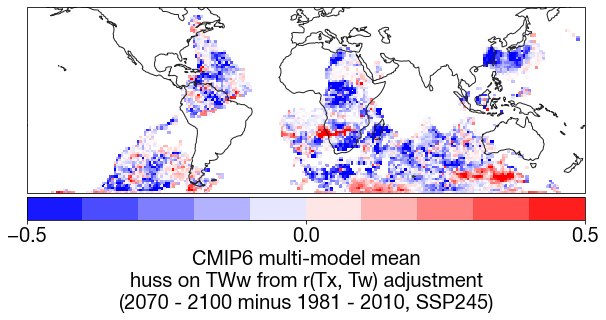

In [35]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tw_on_tww_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - tw_on_tww_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('CMIP6 multi-model mean\nhuss on TWw from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tw-on-tww-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

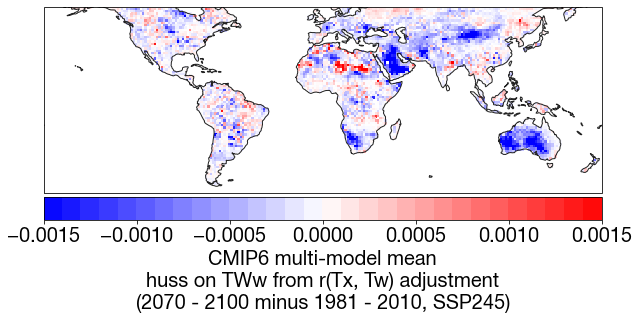

In [33]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5e-3
v2 = 1.51e-3
vstep = .1e-3
vlabelstep = .5e-3

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (huss_on_tww_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - huss_on_tww_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('CMIP6 multi-model mean\nhuss on TWw from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tw-on-tww-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

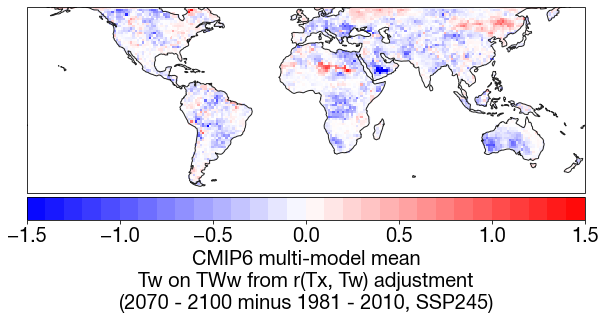

In [101]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tw_on_tww_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - tw_on_tww_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('CMIP6 multi-model mean\nTw on TWw from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tw-on-tww-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

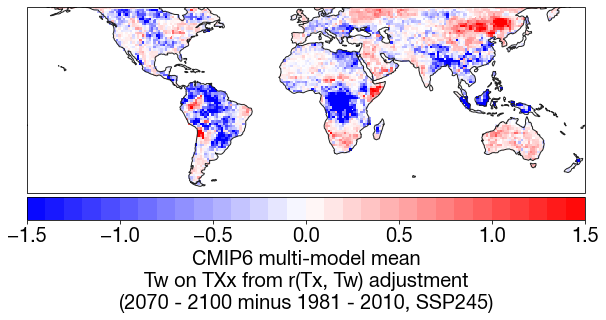

In [29]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tw_on_txx_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - tw_on_txx_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('CMIP6 multi-model mean\nTw on TXx from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tw-on-txx-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


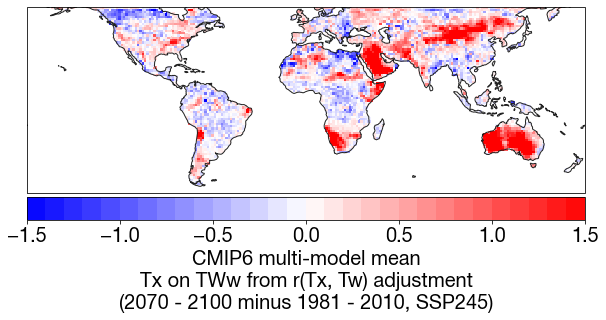

In [30]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tx_on_tww_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - tx_on_tww_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)

cb.set_label('CMIP6 multi-model mean\nTx on TWw from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tx-on-tww-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


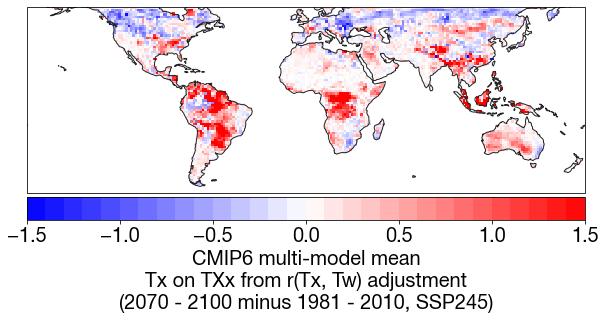

In [31]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tx_on_txx_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - tx_on_txx_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 multi-model mean\nTx on TXx from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tx-on-txx-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


Text(0, 0.5, 'Change in Tw on TXx\nassoc. with r(Tx, Tw) change\n($\\degree$C, difference from 1981-2010)')

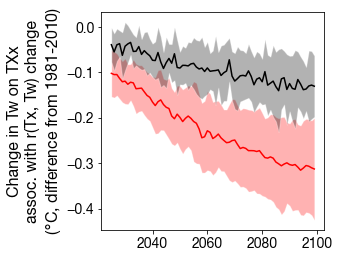

In [72]:
plt.figure(figsize=(4,4))
plt.plot(np.arange(2025,2100), tw_on_txx_cmip6_adj_proj_da_mean.sel(time=slice('2025','2100')).mean(dim='model'), '-r', label = 'Adjusted r(Tx, Tw)\nassociation')
plt.fill_between(np.arange(2025,2100), (tw_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')-tw_on_txx_cmip6_adj_proj_da_mean.std(dim='model')).sel(time=slice('2025','2100')), 
                (tw_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')+tw_on_txx_cmip6_adj_proj_da_mean.std(dim='model')).sel(time=slice('2025','2100')), color='r', alpha=0.3, ec='white')

plt.plot(np.arange(2025,2100), tw_on_txx_cmip6_proj_da_mean.mean(dim='model').sel(time=slice('2025','2100')), '-k', label = 'CMIP6 r(Tx, Tw)\nassociation')
plt.fill_between(np.arange(2025,2100), (tw_on_txx_cmip6_proj_da_mean.mean(dim='model')-tw_on_txx_cmip6_proj_da_mean.std(dim='model')).sel(time=slice('2025','2100')), 
                (tw_on_txx_cmip6_proj_da_mean.mean(dim='model')+tw_on_txx_cmip6_proj_da_mean.std(dim='model')).sel(time=slice('2025','2100')), color='k', alpha=0.3, ec='white')

plt.ylabel('Change in Tw on TXx\nassoc. with r(Tx, Tw) change\n($\degree$C, difference from 1981-2010)')

# l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# l.get_frame().set_linewidth(0)

# plt.savefig('tw-on-txx-from-rtet-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

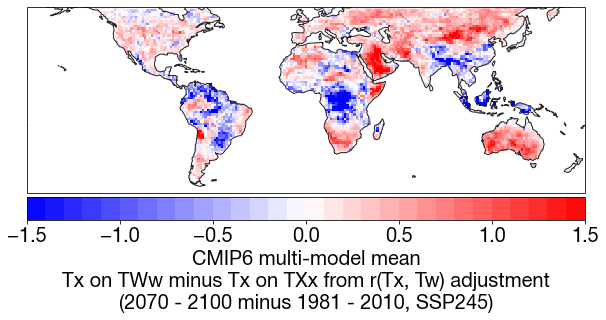

In [239]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - tx_on_tww_minus_tx_on_txx_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 multi-model mean\nTx on TWw minus Tx on TXx from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tx-on-txx-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


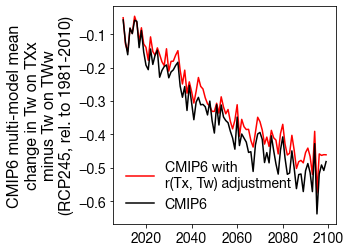

In [73]:

plt.figure(figsize=(4,4))

ymean = (xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww-tx_on_txx_ds.tx_on_txx).sel(time=slice('2010','2099')).mean(dim='model') - \
         (tx_on_tww_minus_tx_on_txx_cmip6_proj_da_mean.mean(dim='model')-tx_on_tww_minus_tx_on_txx_cmip6_adj_proj_da_mean.mean(dim='model'))) - \
            xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww-tx_on_txx_ds.tx_on_txx).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-r', label = 'CMIP6 with\nr(Tx, Tw) adjustment')

ymean = xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww-tx_on_txx_ds.tx_on_txx).sel(time=slice('2010','2099')).mean(dim='model') - \
            xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww-tx_on_txx_ds.tx_on_txx).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-k', label = 'CMIP6')

plt.ylabel('CMIP6 multi-model mean\nchange in Tw on TXx\nminus Tw on TWw\n(RCP245, rel. to 1981-2010)')

l = plt.legend(fontsize=14, framealpha=0)#, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('tw-on-txx-proj-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

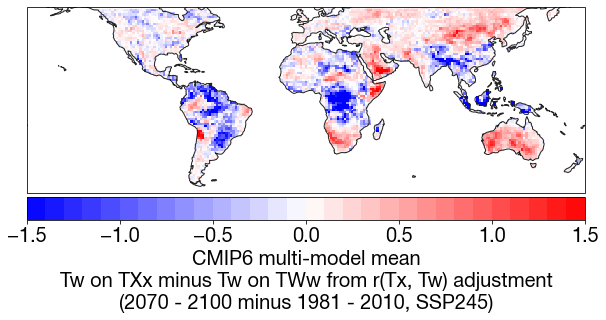

In [234]:


plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1.5
v2 = 1.51
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

data = (tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']) - tw_on_txx_minus_tw_on_tww_cmip6_proj_da.sel(time=slice('2070','2100')).mean(dim=['model','time']))

c = plt.pcolormesh(tx_on_tww_cmip6_adj_proj_da.longitude, tx_on_tww_cmip6_adj_proj_da.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 multi-model mean\nTw on TXx minus Tw on TWw from r(Tx, Tw) adjustment\n(2070 - 2100 minus 1981 - 2010, SSP245)', fontsize=20)

# plt.savefig('tx-on-txx-from-rtet-adj-diff-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


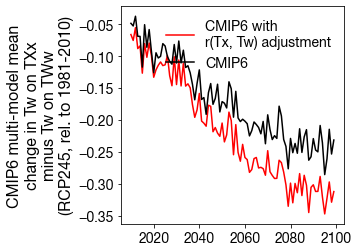

In [74]:
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values)
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values - \
#          (tw_on_txx_cmip6_proj_da_mean.mean(dim='model')-tw_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')).values)

plt.figure(figsize=(4,4))

ymean = (xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx-tw_on_tww_ds.tw_on_tww).sel(time=slice('2010','2099')).mean(dim='model') - \
         (tw_on_txx_minus_tw_on_tww_cmip6_proj_da_mean.mean(dim='model')-tw_on_txx_minus_tw_on_tww_cmip6_adj_proj_da_mean.mean(dim='model'))) - \
            xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx-tw_on_tww_ds.tw_on_tww).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-r', label = 'CMIP6 with\nr(Tx, Tw) adjustment')

ymean = xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx-tw_on_tww_ds.tw_on_tww).sel(time=slice('2010','2099')).mean(dim='model') - \
            xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx-tw_on_tww_ds.tw_on_tww).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-k', label = 'CMIP6')

plt.ylabel('CMIP6 multi-model mean\nchange in Tw on TXx\nminus Tw on TWw\n(RCP245, rel. to 1981-2010)')

l = plt.legend(fontsize=14, framealpha=0)#, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('tw-on-txx-proj-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

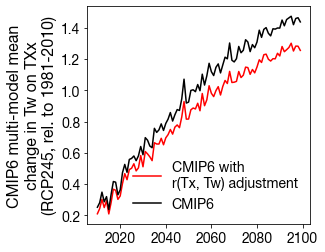

In [75]:
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values)
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values - \
#          (tw_on_txx_cmip6_proj_da_mean.mean(dim='model')-tw_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')).values)

plt.figure(figsize=(4,4))

ymean = (xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model') - \
         (tw_on_txx_cmip6_proj_da_mean.mean(dim='model')-tw_on_txx_cmip6_adj_proj_da_mean.mean(dim='model'))) - \
            xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-r', label = 'CMIP6 with\nr(Tx, Tw) adjustment')

ymean = xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model') - \
            xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-k', label = 'CMIP6')

plt.ylabel('CMIP6 multi-model mean\nchange in Tw on TXx\n(RCP245, rel. to 1981-2010)')

l = plt.legend(fontsize=14, framealpha=0)#, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('tw-on-txx-proj-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

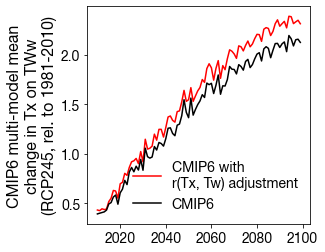

In [204]:
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values)
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values - \
#          (tw_on_txx_cmip6_proj_da_mean.mean(dim='model')-tw_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')).values)

plt.figure(figsize=(4,4))

ymean = (xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('2010','2099')).mean(dim='model') - \
         (tx_on_tww_cmip6_proj_da_mean.mean(dim='model')-tx_on_tww_cmip6_adj_proj_da_mean.mean(dim='model'))) - \
            xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-r', label = 'CMIP6 with\nr(Tx, Tw) adjustment')

ymean = xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('2010','2099')).mean(dim='model') - \
            xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-k', label = 'CMIP6')

plt.ylabel('CMIP6 multi-model mean\nchange in Tx on TWw\n(RCP245, rel. to 1981-2010)')

l = plt.legend(fontsize=14, framealpha=0)#, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
plt.savefig('tx-on-tww-proj-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values)
# plt.plot(xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx).sel(time=slice('2010','2099')).mean(dim='model').values - \
#          (tw_on_txx_cmip6_proj_da_mean.mean(dim='model')-tw_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')).values)

plt.figure(figsize=(4,4))

ymean = (xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('2010','2099')).mean(dim='model') - \
         (tx_on_tww_cmip6_proj_da_mean.mean(dim='model')-tx_on_tww_cmip6_adj_proj_da_mean.mean(dim='model'))) - \
            xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-r', label = 'CMIP6 with\nr(Tx, Tw) adjustment')

ymean = xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('2010','2099')).mean(dim='model') - \
            xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww).sel(time=slice('1981','2010')).mean(dim=['time','model'])

plt.plot(np.arange(2010,2100), ymean, '-k', label = 'CMIP6')

plt.ylabel('CMIP6 multi-model mean\nchange in Tx on TWw\n(RCP245, rel. to 1981-2010)')

l = plt.legend(fontsize=14, framealpha=0)#, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('tw-on-tww-from-rtet-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

Text(0, 0.5, 'Change in Tw on TWw\nassoc. with r(Tx, Tw) change\n($\\degree$C, difference from 1981-2010)')

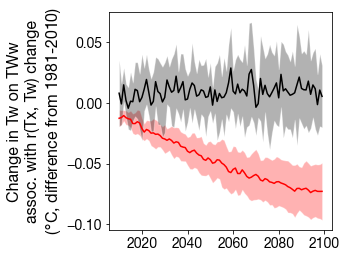

In [76]:
plt.figure(figsize=(4,4))
plt.plot(np.arange(2010,2100), tw_on_tww_cmip6_adj_proj_da_mean.mean(dim='model'), '-r', label = 'Adjusted r(Tx, Tw)\nassociation')
plt.fill_between(np.arange(2010,2100), tw_on_tww_cmip6_adj_proj_da_mean.mean(dim='model')-tw_on_tww_cmip6_adj_proj_da_mean.std(dim='model'), 
                tw_on_tww_cmip6_adj_proj_da_mean.mean(dim='model')+tw_on_tww_cmip6_adj_proj_da_mean.std(dim='model'), color='r', alpha=0.3, ec='white')

plt.plot(np.arange(2010,2100), tw_on_tww_cmip6_proj_da_mean.mean(dim='model'), '-k', label = 'CMIP6 r(Tx, Tw)\nassociation')
plt.fill_between(np.arange(2010,2100), tw_on_tww_cmip6_proj_da_mean.mean(dim='model')-tw_on_tww_cmip6_proj_da_mean.std(dim='model'), 
                tw_on_tww_cmip6_proj_da_mean.mean(dim='model')+tw_on_tww_cmip6_proj_da_mean.std(dim='model'), color='k', alpha=0.3, ec='white')

plt.ylabel('Change in Tw on TWw\nassoc. with r(Tx, Tw) change\n($\degree$C, difference from 1981-2010)')

# l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# l.get_frame().set_linewidth(0)
# plt.savefig('tw-on-tww-from-rtet-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

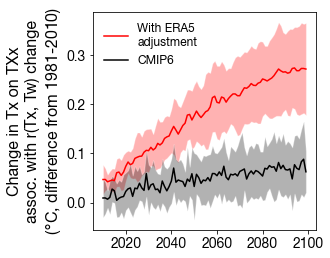

In [77]:
plt.figure(figsize=(4,4))
plt.plot(np.arange(2010,2100), tx_on_txx_cmip6_adj_proj_da_mean.mean(dim='model'), '-r', label = 'With ERA5\nadjustment')
plt.fill_between(np.arange(2010,2100), tx_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')-tx_on_txx_cmip6_adj_proj_da_mean.std(dim='model'), 
                tx_on_txx_cmip6_adj_proj_da_mean.mean(dim='model')+tx_on_txx_cmip6_adj_proj_da_mean.std(dim='model'), color='r', alpha=0.3, ec='white')

plt.plot(np.arange(2010,2100), tx_on_txx_cmip6_proj_da_mean.mean(dim='model'), '-k', label = 'CMIP6')
plt.fill_between(np.arange(2010,2100), tx_on_txx_cmip6_proj_da_mean.mean(dim='model')-tx_on_txx_cmip6_proj_da_mean.std(dim='model'), 
                tx_on_txx_cmip6_proj_da_mean.mean(dim='model')+tx_on_txx_cmip6_proj_da_mean.std(dim='model'), color='k', alpha=0.3, ec='white')

plt.ylabel('Change in Tx on TXx\nassoc. with r(Tx, Tw) change\n($\degree$C, difference from 1981-2010)')

# l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l = plt.legend(fontsize=12, framealpha=.75, loc='upper left')
l.get_frame().set_linewidth(0)

# plt.savefig('tx-on-txx-from-rtet-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

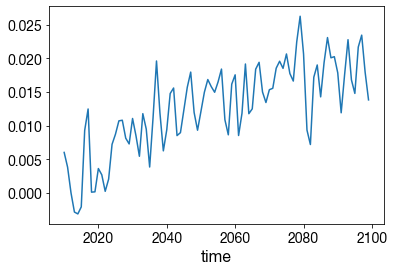

In [78]:
tx_on_tww_cmip6_adj_proj_da_mean.mean(dim='model').plot()

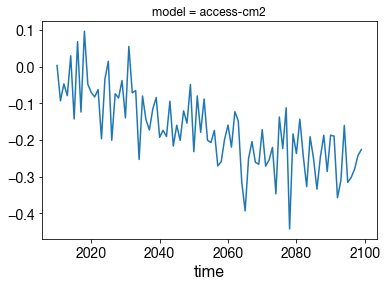

In [79]:
tx_on_tww_cmip6_proj_da_mean[0,:].plot()

Text(0, 0.5, 'Change in Tx on TWw\nassoc. with r(Tx, Tw) change\n($\\degree$C, difference from 1981-2010)')

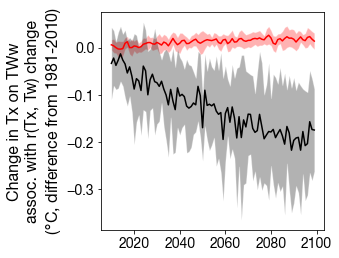

In [80]:

plt.figure(figsize=(4,4))
plt.plot(np.arange(2010,2100), tx_on_tww_cmip6_adj_proj_da_mean.mean(dim='model'), '-r', label = 'Adjusted r(Tx, Tw)\nassociation')
plt.fill_between(np.arange(2010,2100), tx_on_tww_cmip6_adj_proj_da_mean.mean(dim='model')-tx_on_tww_cmip6_adj_proj_da_mean.std(dim='model'), 
                tx_on_tww_cmip6_adj_proj_da_mean.mean(dim='model')+tx_on_tww_cmip6_adj_proj_da_mean.std(dim='model'), color='r', alpha=0.3, ec='white')

plt.plot(np.arange(2010,2100), tx_on_tww_cmip6_proj_da_mean.mean(dim='model'), '-k', label = 'CMIP6 r(Tx, Tw)\nassociation')
plt.fill_between(np.arange(2010,2100), tx_on_tww_cmip6_proj_da_mean.mean(dim='model')-tx_on_tww_cmip6_proj_da_mean.std(dim='model'), 
                tx_on_tww_cmip6_proj_da_mean.mean(dim='model')+tx_on_tww_cmip6_proj_da_mean.std(dim='model'), color='k', alpha=0.3, ec='white')

plt.ylabel('Change in Tx on TWw\nassoc. with r(Tx, Tw) change\n($\degree$C, difference from 1981-2010)')

# plt.savefig('tx-on-tww-from-rtet-adj-ts.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [52]:
era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid = era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid.rename({'lon':'longitude','lat':'latitude'})
era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid = era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid.rename({'lon':'longitude','lat':'latitude'})

[Text(1, 0, 'CMIP6')]

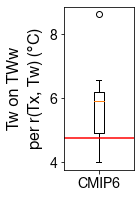

In [54]:
plt.figure(figsize=(1.25,3))
plt.boxplot(xgrid_utils.calc_spatial_mean(cmip6_tx_on_tww_minus_tx_on_txx_per_rtet_da))
plt.plot([.5,1.5], [xgrid_utils.calc_spatial_mean(era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid), xgrid_utils.calc_spatial_mean(era5_tx_on_tww_minus_tx_on_txx_per_rtet_da_regrid)], '-r', label = 'ERA5')

plt.ylabel('Tw on TWw\nper r(Tx, Tw) ($\degree$C)')


# plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(-.1, .9), loc='upper left')
plt.gca().set_xticklabels(['CMIP6'])

# plt.savefig('tw-on-tww-per-rtet-box.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

[Text(1, 0, 'CMIP6')]

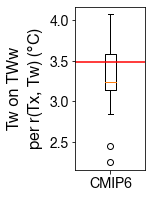

In [53]:
plt.figure(figsize=(1.25,3))
plt.boxplot(xgrid_utils.calc_spatial_mean(cmip6_tw_on_txx_minus_tw_on_tww_per_rtet_da))
plt.plot([.5,1.5], [xgrid_utils.calc_spatial_mean(era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid), xgrid_utils.calc_spatial_mean(era5_tw_on_txx_minus_tw_on_tww_per_rtet_da_regrid)], '-r', label = 'ERA5')

plt.ylabel('Tw on TWw\nper r(Tx, Tw) ($\degree$C)')


# plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(-.1, .9), loc='upper left')
plt.gca().set_xticklabels(['CMIP6'])

# plt.savefig('tw-on-tww-per-rtet-box.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

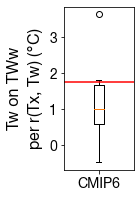

In [42]:
plt.figure(figsize=(1.25,3))
plt.boxplot(xgrid_utils.calc_spatial_mean(cmip6_tw_on_tww_per_rtet_da))
plt.plot([.5,1.5], [xgrid_utils.calc_spatial_mean(era5_tw_on_tww_per_rtet_da),xgrid_utils.calc_spatial_mean(era5_tw_on_tww_per_rtet_da)], '-r', label = 'ERA5')

plt.ylabel('Tw on TWw\nper r(Tx, Tw) ($\degree$C)')


# plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(-.1, .9), loc='upper left')
plt.gca().set_xticklabels(['CMIP6'])

plt.savefig('tw-on-tww-per-rtet-box.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

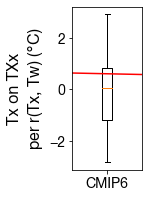

In [115]:
plt.figure(figsize=(1.25,3))
plt.boxplot(xgrid_utils.calc_spatial_mean(cmip6_tx_on_txx_per_rtet_da))
plt.plot([.5,1.5], [xgrid_utils.calc_spatial_mean(era5_tx_on_txx_per_rtet_da),xgrid_utils.calc_spatial_mean(era5_tx_on_txx_per_rtet_da_regrid)], '-r', label='ERA5')


plt.ylabel('Tx on TXx\nper r(Tx, Tw) ($\degree$C)')


# plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(-.1, .9), loc='upper left')
plt.gca().set_xticklabels(['CMIP6'])

plt.savefig('tx-on-txx-per-rtet-box.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

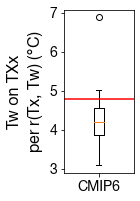

In [116]:
plt.figure(figsize=(1.25,3))
plt.boxplot(xgrid_utils.calc_spatial_mean(cmip6_tw_on_txx_per_rtet_da))
plt.plot([.5,1.5], [xgrid_utils.calc_spatial_mean(era5_tw_on_txx_per_rtet_da),xgrid_utils.calc_spatial_mean(era5_tw_on_txx_per_rtet_da)], '-r', label='ERA5')

plt.ylabel('Tw on TXx\nper r(Tx, Tw) ($\degree$C)')


# plt.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gca().set_xticklabels(['CMIP6'])

plt.savefig('tw-on-txx-per-rtet-box.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

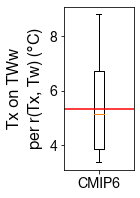

In [119]:
plt.figure(figsize=(1.25,3))
plt.boxplot(xgrid_utils.calc_spatial_mean(cmip6_tx_on_tww_per_rtet_da))
plt.plot([.5,1.5], [xgrid_utils.calc_spatial_mean(era5_tx_on_tww_per_rtet_da),xgrid_utils.calc_spatial_mean(era5_tx_on_tww_per_rtet_da)], '-r', label='ERA5')

plt.ylabel('Tx on TWw\nper r(Tx, Tw) ($\degree$C)')


# plt.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.gca().set_xticklabels(['CMIP6'])
plt.savefig('tx-on-tww-per-rtet-box.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [25]:
recalc = False

from scipy import signal
from statsmodels.tsa.tsatools import detrend

if not recalc:
    with open('cmip6_tw_txx_minus_tw_tww_per_r_tx_tw.dat', 'rb') as f:
        cmip6_tw_txx_minus_tw_tww_per_r_tx_tw = pickle.load(f)
    with open('cmip6_tx_tww_minus_tx_txx_per_r_tx_tw.dat', 'rb') as f:
        cmip6_tx_tww_minus_tx_txx_per_r_tx_tw = pickle.load(f)
        
    with open('cmip6_tw_on_txx_slope.dat', 'rb') as f:
        cmip6_tw_on_txx_slope = pickle.load(f)
    with open('cmip6_tx_on_tww_slope.dat', 'rb') as f:
        cmip6_tx_on_tww_slope = pickle.load(f)
        
    with open('cmip6_tw_on_tww_slope.dat', 'rb') as f:
        cmip6_tw_on_tww_slope = pickle.load(f)
    with open('cmip6_tx_on_txx_slope.dat', 'rb') as f:
        cmip6_tx_on_txx_slope = pickle.load(f)
        
    with open('cmip6_r_tx_tw_slope.dat', 'rb') as f:
        cmip6_r_tx_tw_slope = pickle.load(f)
    with open('cmip6_lh_on_txx_slope.dat', 'rb') as f:
        cmip6_lh_on_txx_slope = pickle.load(f)
    with open('cmip6_huss_on_txx_slope.dat', 'rb') as f:
        cmip6_huss_on_txx_slope = pickle.load(f)
    with open('cmip6_huss_on_tww_slope.dat', 'rb') as f:
        cmip6_huss_on_tww_slope = pickle.load(f)
    with open('cmip6_pr_on_tx_slope.dat', 'rb') as f:
        cmip6_pr_on_tx_slope = pickle.load(f)

else:
    
    cmip6_tw_txx_minus_tw_tww_per_r_tx_tw = np.full([len(cmip6_models), cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_r2 = np.full([len(cmip6_models), cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_tx_tww_minus_tx_txx_per_r_tx_tw = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_r2 = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    
    cmip6_tw_on_txx_slope = np.full([len(cmip6_models), cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_tx_on_tww_slope = np.full([len(cmip6_models), cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_tw_on_tww_slope = np.full([len(cmip6_models), cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_tx_on_txx_slope = np.full([len(cmip6_models), cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    
    cmip6_r_tx_tw_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_lh_on_txx_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_huss_on_txx_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_huss_on_tww_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
    cmip6_pr_on_tx_slope = np.full([len(cmip6_models),cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)


    for m in range(len(cmip6_models)):
        print(f'processing {cmip6_models[m]}')
        for xlat in range(cmip6_hist_corr_spatial.latitude.size):
            for ylon in range(cmip6_hist_corr_spatial.longitude.size):

                if ~np.isnan(cmip6_hist_corr_spatial.tx_tw_corr[m, 1, xlat, ylon]):

                    cur_r_tx_tw = cmip6_hist_corr_spatial.tx_tw_corr.sel(year=slice('1981','2021')).values[m, :, xlat, ylon]

                    cur_tw_on_txx = (tw_on_txx_ds.tw_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon] - \
                            tw_on_tww_ds.tw_on_tww.sel(time=slice('1981','2021')).values[m, :, xlat, ylon])

                    cur_tx_on_tww = (tx_on_tww_ds.tx_on_tww.sel(time=slice('1981','2021')).values[m, :, xlat, ylon] - \
                             tx_on_txx_ds.tx_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon])
                    
                    cur_tw_on_txx = tw_on_txx_ds.tw_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]
                    cur_tw_on_tww = tw_on_tww_ds.tw_on_tww.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]
                    cur_tx_on_tww = tx_on_tww_ds.tx_on_tww.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]
                    cur_tx_on_txx = tx_on_txx_ds.tx_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]
                    cur_lh_on_txx = lh_on_txx_ds.lh_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]
                    cur_huss_on_txx = huss_on_txx_ds.huss_on_txx.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]
                    cur_huss_on_tww = huss_on_tww_ds.huss_on_tww.sel(time=slice('1981','2021')).values[m, :, xlat, ylon]

                    if cmip6_models[m] in cmip6_models_pr:
                        cur_pr_on_tx = pr_on_tx_ds.pr.sel(time=slice('1981','2021')).sel(model=cmip6_models[m]).values[:, xlat, ylon]

                    nn_ts = np.where((~np.isnan(cur_r_tx_tw)) & (~np.isnan(cur_tw_on_txx)) & (~np.isnan(cur_tx_on_tww)))[0]

                    
                    nn = np.where((~np.isnan(cur_r_tx_tw)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_r_tx_tw[nn], X).fit()
                        cmip6_r_tx_tw_slope[m, xlat, ylon] = mdl.params[1]
                    
                    if nn_ts.size > 20:
                        cur_r_tx_tw_detrend = detrend(cur_r_tx_tw[nn_ts], order=1)
                        cur_tw_on_txx_detrend = detrend(cur_tw_on_txx[nn_ts], order=1)
                        cur_tx_on_tww_detrend = detrend(cur_tx_on_tww[nn_ts], order=1)

                        X = sm.add_constant(cur_r_tx_tw_detrend)
                        mdl = sm.OLS(cur_tw_on_txx_detrend, X).fit()
                        cmip6_tw_txx_minus_tw_tww_per_r_tx_tw[m, xlat, ylon] = mdl.params[1]
                        cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_r2[m, xlat, ylon] = mdl.rsquared

                        X = sm.add_constant(cur_r_tx_tw_detrend)
                        mdl = sm.OLS(cur_tx_on_tww_detrend, X).fit()
                        cmip6_tx_tww_minus_tx_txx_per_r_tx_tw[m, xlat, ylon] = mdl.params[1]
                        cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_r2[m, xlat, ylon] = mdl.rsquared

                        X = sm.add_constant(range(nn_ts.size))
                        mdl = sm.OLS(cur_r_tx_tw[nn_ts], X).fit()
                        cmip6_tw_on_txx_slope[m, xlat, ylon] = mdl.params[1]

                    nn = np.where((~np.isnan(cur_tw_on_txx)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_tw_on_txx[nn], X).fit()
                        cmip6_tw_on_txx_slope[m, xlat, ylon] = mdl.params[1]
                        
                    nn = np.where((~np.isnan(cur_tw_on_tww)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_tw_on_tww[nn], X).fit()
                        cmip6_tw_on_tww_slope[m, xlat, ylon] = mdl.params[1]
                        
                    nn = np.where((~np.isnan(cur_tx_on_txx)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_tx_on_txx[nn], X).fit()
                        cmip6_tx_on_txx_slope[m, xlat, ylon] = mdl.params[1]
                                     
                    nn = np.where((~np.isnan(cur_tx_on_tww)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_tx_on_tww[nn], X).fit()
                        cmip6_tx_on_tww_slope[m, xlat, ylon] = mdl.params[1]
                                     
                    nn = np.where((~np.isnan(cur_lh_on_txx)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_lh_on_txx[nn], X).fit()
                        cmip6_lh_on_txx_slope[m, xlat, ylon] = mdl.params[1]
                        
                        
                    nn = np.where((~np.isnan(cur_huss_on_txx)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_huss_on_txx[nn], X).fit()
                        cmip6_huss_on_txx_slope[m, xlat, ylon] = mdl.params[1]
                        
                    nn = np.where((~np.isnan(cur_huss_on_tww)))[0]
                    if nn.size > 20:
                        X = sm.add_constant(range(nn.size))
                        mdl = sm.OLS(cur_huss_on_tww[nn], X).fit()
                        cmip6_huss_on_tww_slope[m, xlat, ylon] = mdl.params[1]

                    if cmip6_models[m] in cmip6_models_pr:
                        nn = np.where((~np.isnan(cur_pr_on_tx)))[0]
                        if nn.size > 20:
                            X = sm.add_constant(range(nn.size))
                            mdl = sm.OLS(cur_pr_on_tx[nn], X).fit()
                            cmip6_pr_on_tx_slope[m, xlat, ylon] = mdl.params[1]

    with open('cmip6_tw_txx_minus_tw_tww_per_r_tx_tw.dat', 'wb') as f:
        pickle.dump(cmip6_tw_txx_minus_tw_tww_per_r_tx_tw, f)
    with open('cmip6_tx_tww_minus_tx_txx_per_r_tx_tw.dat', 'wb') as f:
        pickle.dump(cmip6_tx_tww_minus_tx_txx_per_r_tx_tw, f)
    with open('cmip6_r_tx_tw_slope.dat', 'wb') as f:
        pickle.dump(cmip6_r_tx_tw_slope, f)
                                     
    with open('cmip6_tw_on_txx_slope.dat', 'wb') as f:
        pickle.dump(cmip6_tw_on_txx_slope, f)
    with open('cmip6_tx_on_tww_slope.dat', 'wb') as f:
        pickle.dump(cmip6_tx_on_tww_slope, f)
        
    with open('cmip6_tw_on_tww_slope.dat', 'wb') as f:
        pickle.dump(cmip6_tw_on_tww_slope, f)
    with open('cmip6_tx_on_txx_slope.dat', 'wb') as f:
        pickle.dump(cmip6_tx_on_txx_slope, f)
                                     
    with open('cmip6_lh_on_txx_slope.dat', 'wb') as f:
        pickle.dump(cmip6_lh_on_txx_slope, f)
    with open('cmip6_pr_on_tx_slope.dat', 'wb') as f:
        pickle.dump(cmip6_pr_on_tx_slope, f)
    with open('cmip6_huss_on_txx_slope.dat', 'wb') as f:
        pickle.dump(cmip6_huss_on_txx_slope, f)
    with open('cmip6_huss_on_tww_slope.dat', 'wb') as f:
        pickle.dump(cmip6_huss_on_tww_slope, f)

In [26]:
cmip6_tw_on_tww_slope_da = xr.DataArray(
    cmip6_tw_on_tww_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tw_on_tww_slope_da = cmip6_tw_on_tww_slope_da.reindex(latitude=cmip6_tw_on_tww_slope_da.latitude[::-1])
cmip6_tw_on_tww_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_tw_on_tww_slope_da)

cmip6_tx_on_tww_slope_da = xr.DataArray(
    cmip6_tx_on_tww_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tx_on_tww_slope_da = cmip6_tx_on_tww_slope_da.reindex(latitude=cmip6_tx_on_tww_slope_da.latitude[::-1])
cmip6_tx_on_tww_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_tx_on_tww_slope_da)

cmip6_tx_on_txx_slope_da = xr.DataArray(
    cmip6_tx_on_txx_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tx_on_txx_slope_da = cmip6_tx_on_txx_slope_da.reindex(latitude=cmip6_tx_on_txx_slope_da.latitude[::-1])
cmip6_tx_on_txx_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_tx_on_txx_slope_da)


cmip6_tw_on_txx_slope_da = xr.DataArray(
    cmip6_tw_on_txx_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_tw_on_txx_slope_da = cmip6_tw_on_txx_slope_da.reindex(latitude=cmip6_tw_on_txx_slope_da.latitude[::-1])
cmip6_tw_on_txx_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_tw_on_txx_slope_da)


cmip6_huss_on_txx_slope_da = xr.DataArray(
    cmip6_huss_on_txx_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_huss_on_txx_slope_da = cmip6_huss_on_txx_slope_da.reindex(latitude=cmip6_huss_on_txx_slope_da.latitude[::-1])
cmip6_huss_on_txx_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_huss_on_txx_slope_da)

cmip6_huss_on_tww_slope_da = xr.DataArray(
    cmip6_huss_on_tww_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_huss_on_tww_slope_da = cmip6_huss_on_tww_slope_da.reindex(latitude=cmip6_huss_on_tww_slope_da.latitude[::-1])
cmip6_huss_on_tww_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_huss_on_tww_slope_da)



cmip6_lh_on_txx_slope_da = xr.DataArray(
    cmip6_lh_on_txx_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_lh_on_txx_slope_da = cmip6_lh_on_txx_slope_da.reindex(latitude=cmip6_lh_on_txx_slope_da.latitude[::-1])
cmip6_lh_on_txx_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_lh_on_txx_slope_da)

cmip6_pr_on_tx_slope_da = xr.DataArray(
    cmip6_pr_on_tx_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': huss_on_tww_ds.latitude.values,  # Coordinate for latitude
        'longitude': huss_on_tww_ds.longitude.values  # Coordinate for longitude
    }
)
cmip6_pr_on_tx_slope_da = cmip6_pr_on_tx_slope_da.reindex(latitude=cmip6_pr_on_tx_slope_da.latitude[::-1])
cmip6_pr_on_tx_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_pr_on_tx_slope_da)



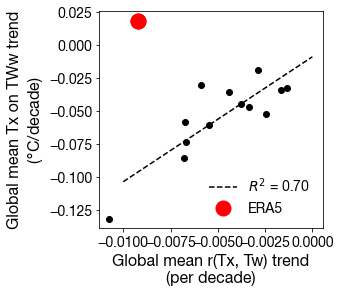

In [256]:
era5_r_t_et_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_slope_da)*10

v1 = cmip6_r_tx_tw_slope_da_means.values*10
v2 = (cmip6_tx_on_tww_slope_da_means.values-cmip6_tx_on_txx_slope_da_means.values)*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.01
x2 = 0

plt.figure(figsize=(4,4))
# plt.xlim([0, .0002])
# plt.ylim([-.02, .28])
plt.scatter(v1, v2, c='k')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
plt.plot([era5_r_t_et_spatial_mean, era5_r_t_et_spatial_mean], [era5_tx_on_tww_da_mean, era5_tx_on_tww_da_mean], 'or', ms=15, label='ERA5')
plt.xlabel('Global mean r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Global mean Tx on TWw trend\n($\degree$C/decade)')
plt.legend(fontsize=14, frameon=False)

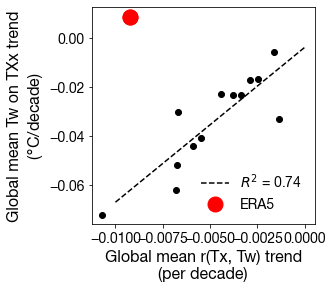

In [258]:
era5_r_t_et_spatial_mean = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_slope_da)*10

v1 = cmip6_r_tx_tw_slope_da_means.values*10
v2 = (cmip6_tw_on_txx_slope_da_means.values-cmip6_tw_on_tww_slope_da_means.values)*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.01
x2 = 0

plt.figure(figsize=(4,4))
# plt.xlim([0, .0002])
# plt.ylim([-.02, .28])
plt.scatter(v1, v2, c='k')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
plt.plot([era5_r_t_et_spatial_mean, era5_r_t_et_spatial_mean], [era5_tw_on_txx_da_mean, era5_tw_on_txx_da_mean], 'or', ms=15, label='ERA5')
plt.xlabel('Global mean r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Global mean Tw on TXx trend\n($\degree$C/decade)')
plt.legend(fontsize=14, frameon=False)

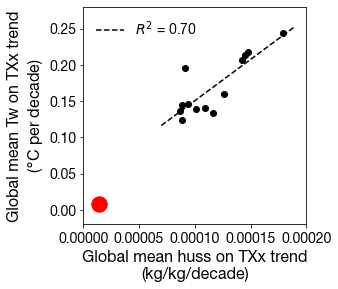

In [222]:
era5_huss_trend_spatial_mean = xgrid_utils.calc_spatial_mean(era5_huss_on_txx_trend['huss_on_txx_trend'].sel(lat=slice(60,-60)).rename({'lat':'latitude', 'lon':'longitude'}))*10

v1 = cmip6_huss_on_txx_slope_da_means.values*10
v2 = cmip6_tw_on_txx_slope_da_means.values*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = 0.00007
x2 = .00019

plt.figure(figsize=(4,4))
plt.xlim([0, .0002])
plt.ylim([-.02, .28])
plt.scatter(v1, v2, c='k')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
plt.plot([era5_huss_trend_spatial_mean, era5_huss_trend_spatial_mean], [era5_tw_on_txx_da_regrid_mean, era5_tw_on_txx_da_regrid_mean], 'or', ms=15)
plt.ylabel('Global mean Tw on TXx trend\n($\degree$C per decade)')
plt.xlabel('Global mean huss on TXx trend\n(kg/kg/decade)')
plt.legend(fontsize=14, frameon=False)

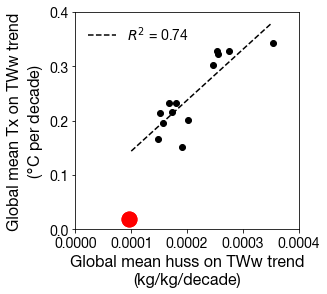

In [250]:
era5_huss_trend_spatial_mean = xgrid_utils.calc_spatial_mean(era5_huss_on_tww_trend['huss_on_tww_trend'].sel(lat=slice(60,-60)).rename({'lat':'latitude', 'lon':'longitude'}))*10

v1 = cmip6_huss_on_tww_slope_da_means.values*10
v2 = cmip6_tx_on_tww_slope_da_means.values*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = 0.0001
x2 = .00035

plt.figure(figsize=(4,4))
plt.xlim([0, .0004])
plt.ylim([0, .4])
plt.scatter(v1, v2, c='k')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
plt.plot([era5_huss_trend_spatial_mean, era5_huss_trend_spatial_mean], [era5_tx_on_tww_da_regrid_mean, era5_tx_on_tww_da_regrid_mean], 'or', ms=15)
plt.ylabel('Global mean Tx on TWw trend\n($\degree$C per decade)')
plt.xlabel('Global mean huss on TWw trend\n(kg/kg/decade)')
plt.legend(fontsize=14, frameon=False)

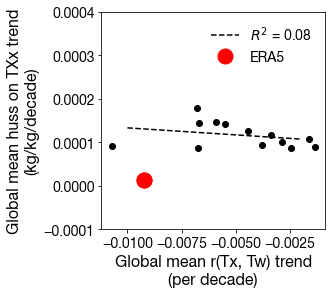

In [117]:
era5_huss_trend_spatial_mean = xgrid_utils.calc_spatial_mean(era5_huss_on_txx_trend['huss_on_txx_trend'].sel(lat=slice(60,-60)).rename({'lat':'latitude', 'lon':'longitude'}))*10

v1 = cmip6_r_tx_tw_slope_da_means.values*10
v2 = cmip6_huss_on_txx_slope_da_means.values*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.01
x2 = -.002

plt.figure(figsize=(4,4))
plt.ylim([-.0001, .0004])
plt.scatter(v1, v2, c='k')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
plt.plot([era5_r_tx_tw_slope_means*10, era5_r_tx_tw_slope_means*10], [era5_huss_trend_spatial_mean, era5_huss_trend_spatial_mean], 'or', ms=15, label='ERA5')
plt.xlabel('Global mean r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Global mean huss on TXx trend\n(kg/kg/decade)')
plt.legend(fontsize=14, frameon=False)

In [62]:
cmip6_r_tx_tw_huss_on_txx_int = []
cmip6_r_tx_tw_huss_on_txx_slope = []
cmip6_r_tx_tw_huss_on_tww_slope = []

for m in range(len(cmip6_models)):
    v1 = cmip6_r_tx_tw_slope_da[m,:,:].values.reshape(cmip6_r_tx_tw_slope_da[0,:,:].values.size)*10
    v2 = cmip6_huss_on_txx_slope_da[m,:,:].values.reshape(cmip6_huss_on_txx_slope_da[0,:,:].values.size)*10
    v3 = cmip6_huss_on_tww_slope_da[m,:,:].values.reshape(cmip6_huss_on_tww_slope_da[0,:,:].values.size)*10
    
    nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)) & (~np.isnan(v3)))[0]
    
    X = sm.add_constant(v1[nn])
    mdl1 = sm.OLS(v2[nn], X).fit()
    cmip6_r_tx_tw_huss_on_txx_int.append(mdl1.params[0])
    cmip6_r_tx_tw_huss_on_txx_slope.append(mdl1.params[1])
    
    X = sm.add_constant(v1[nn])
    mdl2 = sm.OLS(v3[nn], X).fit()
    cmip6_r_tx_tw_huss_on_tww_slope.append(mdl2.params[1])


NameError: name 'cmip6_r_tx_tw_slope_da' is not defined

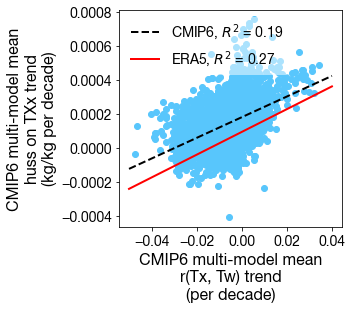

In [109]:
m = 12

# v1 = cmip6_r_tx_tw_slope_da[m,:,:].values.reshape(cmip6_r_tx_tw_slope_da[0,:,:].values.size)*10
# v2 = cmip6_huss_on_txx_slope_da[m,:,:].values.reshape(cmip6_huss_on_txx_slope_da[0,:,:].values.size)*10

v1 = np.nanmean(cmip6_r_tx_tw_slope_da[:,:,:], axis=0).reshape(cmip6_r_tx_tw_slope_da[0,:,:].values.size)*10
v2 = np.nanmean(cmip6_huss_on_txx_slope_da[:,:,:], axis=0).reshape(cmip6_huss_on_txx_slope_da[0,:,:].values.size)*10

# v1 = cmip6_r_tx_tw_slope_da[:,:,:].values.reshape(cmip6_r_tx_tw_slope_da[:,:,:].values.size)*10
# v2 = cmip6_huss_on_txx_slope_da[:,:,:].values.reshape(cmip6_huss_on_txx_slope_da[:,:,:].values.size)*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

x1 = -.05
x2 = .04

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(v1,v2, c='#58c6fc')

# for m in range(len(cmip6_r_tx_tw_huss_on_txx_int)):
#     plt.plot([x1, x2], [cmip6_r_tx_tw_huss_on_txx_int[m] + x1*cmip6_r_tx_tw_huss_on_txx_slope[m], cmip6_r_tx_tw_huss_on_txx_int[m] + x2*cmip6_r_tx_tw_huss_on_txx_slope[m]], '-', c='#aaaaaa')


plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', lw=2, label='CMIP6, $R^2$ = %.2f'%(mdl.rsquared))
plt.plot([x1, x2], [mdl_era5_huss_on_txx.params[0] + x1*mdl_era5_huss_on_txx.params[1], mdl_era5_huss_on_txx.params[0] + x2*mdl_era5_huss_on_txx.params[1]], '-r', lw=2, label='ERA5, $R^2$ = %.2f'%mdl_era5_huss_on_txx.rsquared)


plt.xlabel('CMIP6 multi-model mean\nr(Tx, Tw) trend\n(per decade)')
plt.ylabel('CMIP6 multi-model mean\nhuss on TXx trend\n(kg/kg per decade)')

leg = plt.legend(fontsize=14, framealpha=0.5)
leg.get_frame().set_linewidth(0.0)
plt.savefig('huss_on_txx_vs_r_t_et_cmip6.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

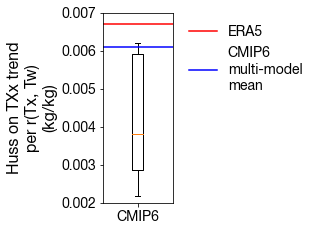

In [112]:
plt.figure(figsize=(1.25,3.5))
plt.ylim([.002, .007])
plt.xlim([.5, 1.5])
plt.boxplot([cmip6_r_tx_tw_huss_on_txx_slope], positions=[1])
plt.plot([.5, 1.5], [mdl_era5_huss_on_txx.params[1], mdl_era5_huss_on_txx.params[1]], '-r', label='ERA5')
plt.plot([.5, 1.5], [mdl.params[1], mdl.params[1]], '-b', label='CMIP6\nmulti-model\nmean')
plt.xticks([1], rotation=0)
plt.gca().set_xticklabels(['CMIP6'])
plt.ylabel('Huss on TXx trend\nper r(Tx, Tw)\n(kg/kg)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
plt.savefig('huss_on_txx_slope_cmip6_era5.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

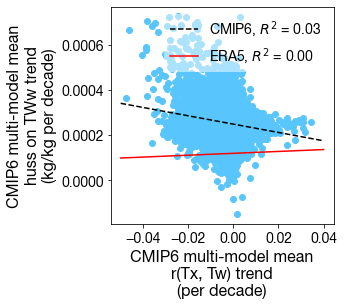

In [114]:
m = 3

# v1 = cmip6_r_tx_tw_slope_da[m,:,:].values.reshape(cmip6_r_tx_tw_slope_da[0,:,:].values.size)*10
# v2 = cmip6_huss_on_tww_slope_da[m,:,:].values.reshape(cmip6_huss_on_tww_slope_da[0,:,:].values.size)*10

v1 = np.nanmean(cmip6_r_tx_tw_slope_da[:,:,:], axis=0).reshape(cmip6_r_tx_tw_slope_da[0,:,:].values.size)*10
v2 = np.nanmean(cmip6_huss_on_tww_slope_da[:,:,:], axis=0).reshape(cmip6_huss_on_tww_slope_da[0,:,:].values.size)*10

# v1 = cmip6_r_tx_tw_slope_da[:,:,:].values.reshape(cmip6_r_tx_tw_slope_da[:,:,:].values.size)*10
# v2 = cmip6_huss_on_tww_slope_da[:,:,:].values.reshape(cmip6_huss_on_tww_slope_da[:,:,:].values.size)*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]
 
x1 = -.05
x2 = .04

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

plt.figure(figsize=(4,4))
plt.scatter(v1,v2, c='#58c6fc')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='CMIP6, $R^2$ = %.2f'%mdl.rsquared)
plt.plot([x1, x2], [mdl_era5_huss_on_tww.params[0] + x1*mdl_era5_huss_on_tww.params[1], mdl_era5_huss_on_tww.params[0] + x2*mdl_era5_huss_on_tww.params[1]], '-r', label='ERA5, $R^2$ = %.2f'%mdl_era5_huss_on_tww.rsquared)

plt.xlabel('CMIP6 multi-model mean\nr(Tx, Tw) trend\n(per decade)')
plt.ylabel('CMIP6 multi-model mean\nhuss on TWw trend\n(kg/kg per decade)')

leg = plt.legend(fontsize=14, framealpha=0.5)
leg.get_frame().set_linewidth(0.0)
plt.savefig('huss_on_tww_vs_r_t_et_cmip6.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

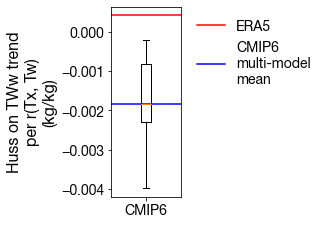

In [115]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([.002, .007])
plt.xlim([.5, 1.5])
plt.boxplot([cmip6_r_tx_tw_huss_on_tww_slope], positions=[1])
plt.plot([.5, 1.5], [mdl_era5_huss_on_tww.params[1], mdl_era5_huss_on_tww.params[1]], '-r', label='ERA5')
plt.plot([.5, 1.5], [mdl.params[1], mdl.params[1]], '-b', label='CMIP6\nmulti-model\nmean')
plt.xticks([1], rotation=0)
plt.gca().set_xticklabels(['CMIP6'])
plt.ylabel('Huss on TWw trend\nper r(Tx, Tw)\n(kg/kg)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
plt.savefig('huss_on_tww_slope_cmip6_era5.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

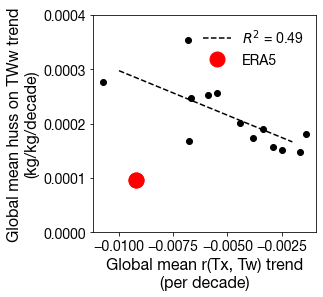

In [116]:
era5_huss_trend_spatial_mean = xgrid_utils.calc_spatial_mean(era5_huss_on_tww_trend['huss_on_tww_trend'].sel(lat=slice(60,-60)).rename({'lat':'latitude', 'lon':'longitude'}))*10

v1 = cmip6_r_tx_tw_slope_da_means.values*10
v2 = cmip6_huss_on_tww_slope_da_means.values*10

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()

x1 = -.01
x2 = -.002

plt.figure(figsize=(4,4))
plt.ylim([0, .0004])
plt.scatter(v1, v2, c='k')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
plt.plot([era5_r_tx_tw_slope_means*10, era5_r_tx_tw_slope_means*10], [era5_huss_trend_spatial_mean, era5_huss_trend_spatial_mean], 'or', ms=15, label='ERA5')
plt.xlabel('Global mean r(Tx, Tw) trend\n(per decade)')
plt.ylabel('Global mean huss on TWw trend\n(kg/kg/decade)')
plt.legend(fontsize=14, frameon=False)

In [27]:
with open('era5_r_tx_tw_vs_tw_on_tx_slope.dat', 'rb') as f:
    era5_tw_txx_minus_tw_tww_per_r_tx_tw = pickle.load(f)
    
    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude, 'lon':land_sea_mask_60.longitude, 'era5_tw_txx_minus_tw_tww_per_r_tx_tw':era5_tw_txx_minus_tw_tww_per_r_tx_tw}, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
    era5_tw_txx_minus_tw_tww_per_r_tx_tw_regrid = regridder(era5_tw_txx_minus_tw_tww_per_r_tx_tw);

with open('era5_r_tx_tw_vs_tx_on_tw_slope.dat', 'rb') as f:
    era5_tx_tww_minus_tx_txx_per_r_tx_tw = pickle.load(f)
    
    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude, 'lon':land_sea_mask_60.longitude, 'era5_tx_tww_minus_tx_txx_per_r_tx_tw':era5_tx_tww_minus_tx_txx_per_r_tx_tw}, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
    era5_tx_tww_minus_tx_txx_per_r_tx_tw_regrid = regridder(era5_tx_tww_minus_tx_txx_per_r_tx_tw);
    
with open('era5_r_tx_tw_slope.dat', 'rb') as f:
    era5_r_tx_tw_slope = pickle.load(f)

    regridder = xe.Regridder({'lat':land_sea_mask_60.latitude, 'lon':land_sea_mask_60.longitude, 'r_tx_tw_slope':era5_r_tx_tw_slope}, regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
    era5_r_tx_tw_slope_regrid = regridder(era5_r_tx_tw_slope);
    

Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.


In [28]:

cmip6_r_tx_tw_slope_da = xr.DataArray(
    cmip6_r_tx_tw_slope,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': cmip6_lat_sel.lat.values,  # Coordinate for latitude
        'longitude': cmip6_lon_sel.lon.values  # Coordinate for longitude
    }
)

cmip6_r_tx_tw_slope_da = cmip6_r_tx_tw_slope_da.reindex(latitude=cmip6_r_tx_tw_slope_da.latitude[::-1])

cmip6_r_tx_tw_slope_da_means = xgrid_utils.calc_spatial_mean(cmip6_r_tx_tw_slope_da)


cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da = xr.DataArray(
    cmip6_tw_txx_minus_tw_tww_per_r_tx_tw,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': cmip6_lat_sel.lat.values,  # Coordinate for latitude
        'longitude': cmip6_lon_sel.lon.values  # Coordinate for longitude
    }
)

cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da = cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da.reindex(latitude=cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da.latitude[::-1])

cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da)


cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da = xr.DataArray(
    cmip6_tx_tww_minus_tx_txx_per_r_tx_tw,  # Data
    dims=['model', 'latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': cmip6_lat_sel.lat.values,  # Coordinate for latitude
        'longitude': cmip6_lon_sel.lon.values  # Coordinate for longitude
    }
)
cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da = cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da.reindex(latitude=cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude[::-1])

cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da)



era5_r_tx_tw_slope_da = xr.DataArray(
    era5_r_tx_tw_slope,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_r_tx_tw_slope_da.latitude.values, 'lon':era5_r_tx_tw_slope_da.longitude.values, 'data':era5_r_tx_tw_slope_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_r_tx_tw_slope_da_regrid = regridder(era5_r_tx_tw_slope_da)
era5_r_tx_tw_slope_da_regrid = era5_r_tx_tw_slope_da_regrid.reindex(lat=era5_r_tx_tw_slope_da_regrid.lat[::-1])

era5_r_tx_tw_slope_means = xgrid_utils.calc_spatial_mean(era5_r_tx_tw_slope_da)

era5_tx_tww_minus_tx_txx_per_r_tx_tw_da = xr.DataArray(
    era5_tx_tww_minus_tx_txx_per_r_tx_tw,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude.values, 'lon':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.longitude.values, 'data':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid = regridder(era5_tx_tww_minus_tx_txx_per_r_tx_tw_da)
era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid = era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid.reindex(lat=era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_regrid.lat[::-1])


era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(era5_tx_tww_minus_tx_txx_per_r_tx_tw_da)

era5_tw_txx_minus_tw_tww_per_r_tx_tw_da = xr.DataArray(
    era5_tw_txx_minus_tw_tww_per_r_tx_tw,  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)
regridder = xe.Regridder({'lat':era5_tw_txx_minus_tw_tww_per_r_tx_tw_da.latitude.values, 'lon':era5_tw_txx_minus_tw_tww_per_r_tx_tw_da.longitude.values, 'data':era5_tw_txx_minus_tw_tww_per_r_tx_tw_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid = regridder(era5_tw_txx_minus_tw_tww_per_r_tx_tw_da)
era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid = era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.reindex(lat=era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.lat[::-1])

era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_means = xgrid_utils.calc_spatial_mean(era5_tw_txx_minus_tw_tww_per_r_tx_tw_da)



era5_tw_on_tww_da = xr.DataArray(
    tw_on_tw_trend['tw_on_warm_season_trend'][-1,:,:].sel(latitude=slice(60,-60)),  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude.values, 'lon':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.longitude.values, 'data':era5_tw_on_tww_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_tww_da_regrid = regridder(era5_tw_on_tww_da)
era5_tw_on_tww_da_regrid = era5_tw_on_tww_da_regrid.reindex(lat=era5_tw_on_tww_da_regrid.lat[::-1])

era5_tw_on_tww_da_mean = xgrid_utils.calc_spatial_mean(era5_tw_on_tww_da)
era5_tw_on_tww_da_regrid_mean = xgrid_utils.calc_spatial_mean(era5_tw_on_tww_da_regrid.rename({'lat':'latitude', 'lon':'longitude'}))


era5_tw_on_txx_da = xr.DataArray(
    tw_on_tx_trend['tw_on_warm_season_tx_trend'][-1,:,:].sel(latitude=slice(60,-60)),  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude.values, 'lon':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.longitude.values, 'data':era5_tw_on_txx_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tw_on_txx_da_regrid = regridder(era5_tw_on_txx_da)
era5_tw_on_txx_da_regrid = era5_tw_on_txx_da_regrid.reindex(lat=era5_tw_on_txx_da_regrid.lat[::-1])

era5_tw_on_txx_da_mean = xgrid_utils.calc_spatial_mean(era5_tw_on_txx_da)
era5_tw_on_txx_da_regrid_mean = xgrid_utils.calc_spatial_mean(era5_tw_on_txx_da_regrid.rename({'lat':'latitude', 'lon':'longitude'}))


era5_tx_on_txx_da = xr.DataArray(
    tx_on_tx_trend['tx_on_warm_season_trend'][-1,:,:].sel(latitude=slice(60,-60)),  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude.values, 'lon':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.longitude.values, 'data':era5_tx_on_txx_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_txx_da_regrid = regridder(era5_tx_on_txx_da)
era5_tx_on_txx_da_regrid = era5_tx_on_txx_da_regrid.reindex(lat=era5_tx_on_txx_da_regrid.lat[::-1])

era5_tx_on_txx_da_mean = xgrid_utils.calc_spatial_mean(era5_tx_on_txx_da)
era5_tx_on_txx_da_regrid_mean = xgrid_utils.calc_spatial_mean(era5_tx_on_txx_da_regrid.rename({'lat':'latitude', 'lon':'longitude'}))


era5_tx_on_tww_da = xr.DataArray(
    tx_on_tw_trend['tx_on_warm_season_tw_trend'][-1,:,:].sel(latitude=slice(60,-60)),  # Data
    dims=['latitude', 'longitude'],  # Dimension names
    coords={
        'latitude': land_sea_mask_60.latitude.values,  # Coordinate for latitude
        'longitude': land_sea_mask_60.longitude.values  # Coordinate for longitude
    }
)

regridder = xe.Regridder({'lat':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.latitude.values, 'lon':era5_tx_tww_minus_tx_txx_per_r_tx_tw_da.longitude.values, 'data':era5_tx_on_tww_da}, 
                         {'lat': regridMesh_global.sel(lat=slice(-60,60)).lat.values, 'lon': regridMesh_global.sel(lat=slice(-60,60)).lon.values}, 'bilinear', reuse_weights=False)
era5_tx_on_tww_da_regrid = regridder(era5_tx_on_tww_da)
era5_tx_on_tww_da_regrid = era5_tx_on_tww_da_regrid.reindex(lat=era5_tx_on_tww_da_regrid.lat[::-1])

era5_tx_on_tww_da_mean = xgrid_utils.calc_spatial_mean(era5_tx_on_tww_da)
era5_tx_on_tww_da_regrid_mean = xgrid_utils.calc_spatial_mean(era5_tx_on_tww_da_regrid.rename({'lat':'latitude', 'lon':'longitude'}))


Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_481x1440_81x240.nc 
 You can set reuse_weights=True to save computing time.


In [29]:
era5_huss_on_txx_mean = xr.open_dataset('era5_huss_on_txx_mean.nc')
cmip6_mm_huss_on_txx_1d = huss_on_txx_ds.huss_on_txx[:,0,:,:].mean(dim='model').values
cmip6_mm_huss_on_txx_1d = cmip6_mm_huss_on_txx_1d.reshape([cmip6_mm_huss_on_txx_1d.size])

era5_huss_on_txx_mean_regrid_1d = era5_huss_on_txx_mean_regrid.reshape([era5_huss_on_txx_mean_regrid.size])

NameError: name 'era5_huss_on_txx_mean_regrid' is not defined

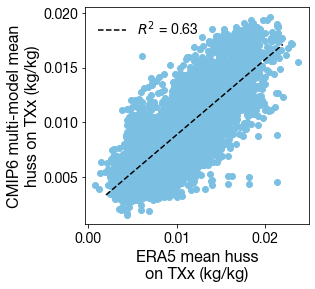

In [27]:
v1 = era5_huss_on_txx_mean_regrid_1d
v2 = cmip6_mm_huss_on_txx_1d

nn = np.where((~np.isnan(v1)) & (~np.isnan(v2)))[0]

X = sm.add_constant(v1[nn])
mdl = sm.OLS(v2[nn], X).fit()


x1 = 0.002
x2 = .022

plt.figure(figsize=(4,4))
plt.scatter(v1, v2, c='#7bc0e3')
plt.plot([x1, x2], [mdl.params[0] + x1*mdl.params[1], mdl.params[0] + x2*mdl.params[1]], '--k', label='$R^2$ = %.2f'%mdl.rsquared)
plt.xlabel('ERA5 mean huss\non TXx (kg/kg)')
plt.ylabel('CMIP6 multi-model mean\nhuss on TXx (kg/kg)')
plt.legend(frameon=False, fontsize=14)

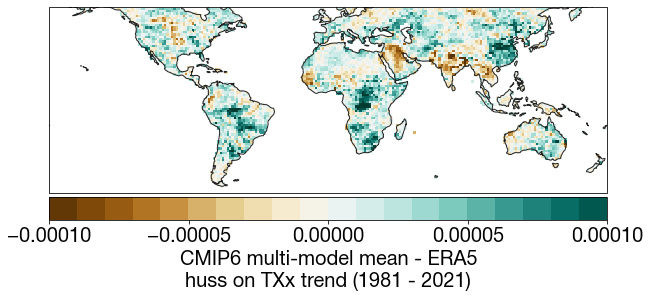

In [113]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.0001
v2 = .00011
vstep = .00001
vlabelstep = .00005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_huss_on_txx_slope,axis=0)-era5_huss_on_txx_trend_regrid

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 multi-model mean - ERA5\nhuss on TXx trend (1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


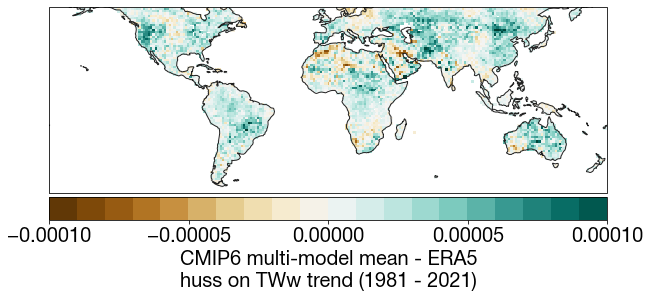

In [125]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.0001
v2 = .00011
vstep = .00001
vlabelstep = .00005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_huss_on_tww_slope,axis=0)-era5_huss_on_tww_trend_regrid

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 multi-model mean - ERA5\nhuss on TWw trend (1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
# m=0

# cmip6_r_tx_tw_slope_1d = cmip6_r_tx_tw_slope[m,:,:].reshape([cmip6_r_tx_tw_slope[0,:,:].size])
# cmip6_lh_on_tx_slope_1d = cmip6_lh_on_tx_slope[m,:,:].reshape([cmip6_lh_on_tx_slope[0,:,:].size])
# cmip6_pr_on_tx_slope_1d = cmip6_pr_on_tx_slope[m,:,:].reshape([cmip6_lh_on_tx_slope[0,:,:].size])*3600*1000

cmip6_r_tx_tw_slope_1d = np.nanmean(cmip6_r_tx_tw_slope,axis=0).reshape([cmip6_r_tx_tw_slope[0,:,:].size])
cmip6_lh_on_txx_slope_1d = np.nanmean(cmip6_lh_on_txx_slope,axis=0).reshape([cmip6_lh_on_txx_slope[0,:,:].size])
cmip6_huss_on_txx_slope_1d = np.nanmean(cmip6_huss_on_txx_slope,axis=0).reshape([cmip6_huss_on_txx_slope[0,:,:].size])
# cmip6_huss_on_txx_slope_1d = np.nanmean(cmip6_huss_on_tww_slope,axis=0).reshape([cmip6_huss_on_txx_slope[0,:,:].size])
cmip6_pr_on_tx_slope_1d = np.nanmean(cmip6_pr_on_tx_slope,axis=0).reshape([cmip6_lh_on_txx_slope[0,:,:].size])*3600*1000

In [ ]:

tx_tw_corr_trend_percentile_levels = np.nanpercentile(cmip6_r_tx_tw_slope_1d, np.arange(1,99))
abs_diff = np.abs(cmip6_r_tx_tw_slope_1d[:, np.newaxis] - tx_tw_corr_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
tx_tw_corr_trend_percentiles_1d = min_diff_indices.astype(float)
tx_tw_corr_trend_percentiles_1d[tx_tw_corr_trend_percentiles_1d == 0] = np.nan


lh_on_txx_trend_percentile_levels = np.nanpercentile(cmip6_lh_on_txx_slope_1d, np.arange(1,99))
abs_diff = np.abs(cmip6_lh_on_txx_slope_1d[:, np.newaxis] - lh_on_txx_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
lh_on_txx_trend_percentiles_1d = min_diff_indices.astype(float)
lh_on_txx_trend_percentiles_1d[lh_on_txx_trend_percentiles_1d == 0] = np.nan


huss_on_txx_trend_percentile_levels = np.nanpercentile(cmip6_huss_on_txx_slope_1d, np.arange(1,99))
abs_diff = np.abs(cmip6_huss_on_txx_slope_1d[:, np.newaxis] - huss_on_txx_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
huss_on_txx_trend_percentiles_1d = min_diff_indices.astype(float)
huss_on_txx_trend_percentiles_1d[huss_on_txx_trend_percentiles_1d == 0] = np.nan



pr_on_tx_trend_percentile_levels = np.nanpercentile(cmip6_pr_on_tx_slope_1d, np.arange(1,99))
abs_diff = np.abs(cmip6_pr_on_tx_slope_1d[:, np.newaxis] - pr_on_tx_trend_percentile_levels)
nn = np.where(~np.isnan(abs_diff[:,0]))[0]

# Find the index of the minimum difference for each data point
min_diff_indices = np.argmin(abs_diff, axis=1)

# Map the indices of the minimum difference to the corresponding percentile
pr_on_tx_trend_percentiles_1d = min_diff_indices.astype(float)
pr_on_tx_trend_percentiles_1d[pr_on_tx_trend_percentiles_1d == 0] = np.nan



In [118]:
tx_tw_corr_trend_deciles_inds = {}
for i in range(10, 101, 10):
    tx_tw_corr_trend_deciles_inds[i] = np.where((tx_tw_corr_trend_percentiles_1d < i) & (tx_tw_corr_trend_percentiles_1d >= i-10))[0]

In [119]:
nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(huss_on_txx_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_huss = sm.OLS(huss_on_txx_trend_percentiles_1d[nn],X).fit()
mdl_huss.summary();

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(lh_on_txx_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_lh = sm.OLS(lh_on_txx_trend_percentiles_1d[nn],X).fit()
mdl_lh.summary();

nn = np.where(~np.isnan(tx_tw_corr_trend_percentiles_1d) & ~np.isnan(pr_on_tx_trend_percentiles_1d))[0]
X = sm.add_constant(tx_tw_corr_trend_percentiles_1d[nn])
mdl_pr = sm.OLS(pr_on_tx_trend_percentiles_1d[nn],X).fit()
mdl_pr.summary();

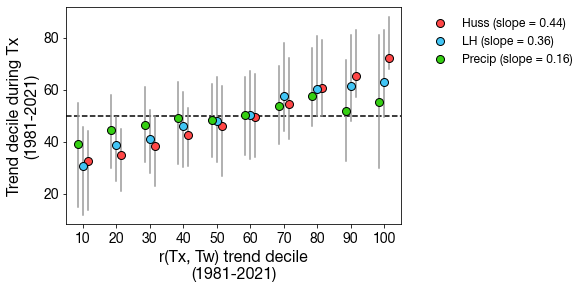

In [120]:

plt.xlim([0,20])
plt.plot([0,21], [50,50], '--', color='k')

x=1
for i in tx_tw_corr_trend_deciles_inds.keys():
    cur_var = huss_on_txx_trend_percentiles_1d
    cur_x = x+.3
    y1 = np.nanpercentile(cur_var[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(cur_var[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x,cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(cur_var[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#ff4747', mew=1, label='Huss (slope = %.2f)'%mdl_huss.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(cur_var[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#ff4747', mew=1)
        
        
    cur_var = lh_on_txx_trend_percentiles_1d
    cur_x = x
    y1 = np.nanpercentile(cur_var[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(cur_var[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x,cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(cur_var[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#42c5f5', mew=1, label='LH (slope = %.2f)'%mdl_lh.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(cur_var[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#42c5f5', mew=1)
        
    cur_var = pr_on_tx_trend_percentiles_1d
    cur_x = x-.3
    y1 = np.nanpercentile(cur_var[tx_tw_corr_trend_deciles_inds[i]], 33)
    y2 = np.nanpercentile(cur_var[tx_tw_corr_trend_deciles_inds[i]], 67)
    plt.plot([cur_x,cur_x], [y1, y2], '-', c='#999999')
    if i == 10:
        plt.plot([cur_x], [np.nanmean(cur_var[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1, label='Precip (slope = %.2f)'%mdl_pr.params[1])
    else:
        plt.plot([cur_x], [np.nanmean(cur_var[tx_tw_corr_trend_deciles_inds[i]])], 'o', ms=8, mec='k', mfc='#35cf13', mew=1)
    x+=2
    
deciles = np.arange(10, 101, 10) 
plt.xticks(np.arange(1,21,2))
plt.gca().set_xticklabels(deciles)
plt.xlabel('r(Tx, Tw) trend decile\n(1981-2021)')

plt.ylabel('Trend decile during Tx\n(1981-2021)')

plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [ ]:

cmip6_tw_on_txx_era5_proj_ts = np.full([len(cmip6_models), np.arange(2010,2100).size, cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)
cmip6_tx_on_tww_era5_proj_ts = np.full([len(cmip6_models), np.arange(2010,2100).size, cmip6_hist_corr_spatial.latitude.size, cmip6_hist_corr_spatial.longitude.size], np.nan)

for m in range(len(cmip6_models)):
    print(cmip6_models[m])
    
    # full tw_on_tx change
    cur_model_full_tw_on_tx_chg = (((tw_on_txx_ds.tw_on_txx[m,:,:,:]-tw_on_tww_ds.tw_on_tww[m,:,:,:]).sel(time=slice('2010', '2100')) - \
                                    (tw_on_txx_ds.tw_on_txx[m,:,:,:]-tw_on_tww_ds.tw_on_tww[m,:,:,:]).sel(time=slice('1981', '2010')).mean(dim='time')).values)
    
    # slope r(tx,tw) vs tw_on_tx
    cur_model_tw_on_tx_per_r_tx_tw = cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da[m,:,:].values
    
    # r(tx,tw) change
    cur_model_r_tx_tw_chg = (cmip6_hist_corr_spatial.tx_tw_corr[m,:,:,:].sel(year=slice('2010', '2100')) - cmip6_hist_corr_spatial.tx_tw_corr[m,:,:,:].sel(year=slice('1981', '2010')).mean(dim='year')).values
    
    cur_cmip6_era5_adjusted_r_tx_tw_chg = cmip6_rtxtw_gmt_chg[m].values
    
    for xlat in range(cmip6_hist_corr_spatial.latitude.size):
        for ylon in range(cmip6_hist_corr_spatial.longitude.size):
            
            cur_cmip6_full_tw_on_tx_chg_gridcell = cur_model_full_tw_on_tx_chg[:, xlat, ylon]
            cur_model_tw_on_tx_per_r_tx_tw_gridcell = cur_model_tw_on_tx_per_r_tx_tw[xlat, ylon]
            cur_cmip6_r_tx_tw_chg_gridcell = cur_model_r_tx_tw_chg[:, xlat, ylon]
            cur_cmip6_era5_adjusted_r_tx_tw_chg_gridcell = cur_cmip6_era5_adjusted_r_tx_tw_chg[:, xlat, ylon]
            
            nn = np.where(~np.isnan(cur_cmip6_r_tx_tw_chg_gridcell))[0]
            
            for y in range(np.arange(2010,2100).size):
                if nn.size > 10:
                    cmip6_tw_on_txx_era5_proj_ts[m, y, xlat, ylon] = cur_cmip6_full_tw_on_tx_chg_gridcell[y] - \
                                                                        cur_cmip6_r_tx_tw_chg_gridcell[y] * cur_model_tw_on_tx_per_r_tx_tw_gridcell + \
                                                                        cur_cmip6_era5_adjusted_r_tx_tw_chg_gridcell[y] * era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_regrid.values[xlat, ylon]


#                     cmip6_tw_on_txx_era5_proj_ts[m, y, xlat, ylon] = cur_cmip6_r_tx_tw_chg_gridcell[y] * era5_r_tx_tw_vs_tw_on_tx_slope_mean[xlat, ylon]
#                     cmip6_tx_on_tww_era5_proj_ts[m, y, xlat, ylon] = cur_cmip6_r_tx_tw_chg_gridcell[y] * era5_r_tx_tw_vs_tx_on_tw_slope_mean[xlat, ylon]


In [ ]:
cmip6_tw_on_txx_era5_proj_ts_da = xr.DataArray(
    data=cmip6_tw_on_txx_era5_proj_ts,  # Use your data array here
    dims=["model", "time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "model":cmip6_models,
        "time":np.arange(2010,2100),
        "latitude": cmip6_hist_corr_spatial.latitude.values,  # Latitude coordinates
        "longitude": cmip6_hist_corr_spatial.longitude.values  # Longitude coordinates
    }
)

cmip6_tx_on_tww_era5_proj_ts_da = xr.DataArray(
    data=cmip6_tx_on_tww_era5_proj_ts,  # Use your data array here
    dims=["model", "time", "latitude", "longitude"],  # Specify the dimensions names
    coords={
        "model":cmip6_models,
        "time":np.arange(2010,2100),
        "latitude": cmip6_hist_corr_spatial.latitude.values,  # Latitude coordinates
        "longitude": cmip6_hist_corr_spatial.longitude.values  # Longitude coordinates
    }
)

cmip6_tw_on_txx_era5_proj_ts_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_tw_on_txx_era5_proj_ts_da)
cmip6_tx_on_tww_era5_proj_ts_spatial_mean = xgrid_utils.calc_spatial_mean(cmip6_tx_on_tww_era5_proj_ts_da)


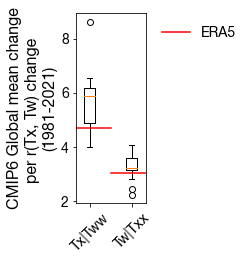

In [194]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.xlim([.5, 1.5])
plt.boxplot([cmip6_tx_tww_minus_tx_txx_per_r_tx_tw_da_means, cmip6_tw_txx_minus_tw_tww_per_r_tx_tw_da_means], positions=[.7, 1.3])
plt.plot([.5, 1], [era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_means, era5_tx_tww_minus_tx_txx_per_r_tx_tw_da_means], '-r', label='ERA5')
plt.plot([1, 1.5], [era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_means, era5_tw_txx_minus_tw_tww_per_r_tx_tw_da_means], '-r')
plt.xticks([.7,1.3], rotation=45)
plt.gca().set_xticklabels(['Tx|Tww', 'Tw|Txx'])
plt.ylabel('CMIP6 Global mean change\nper r(Tx, Tw) change \n(1981-2021)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-lens-era5-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

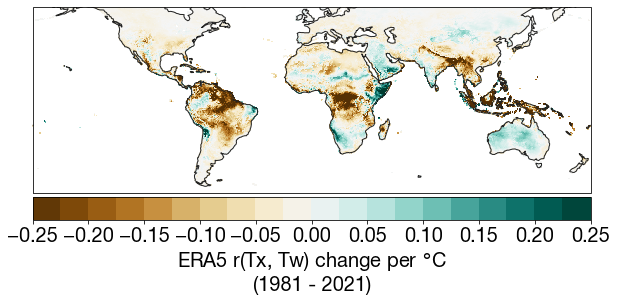

In [85]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = era5_r_tx_tw_per_deg

c = plt.pcolormesh(land_sea_mask_60.longitude, land_sea_mask_60.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 r(Tx, Tw) change per $\degree$C\n(1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


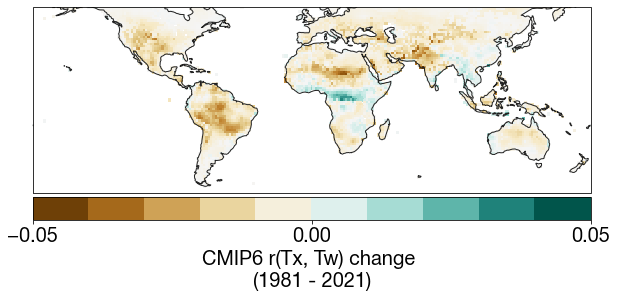

In [86]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, -180, 60, -60])

v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_r_tx_tw_slope, axis=0)*10

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 r(Tx, Tw) change \n(1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


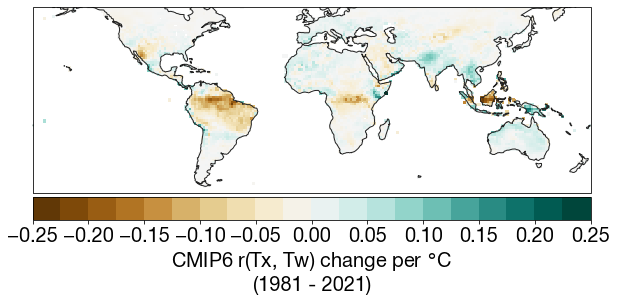

In [87]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_r_tx_tw_per_deg, axis=0)

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 r(Tx, Tw) change per $\degree$C\n(1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
regridder = xe.Regridder({'lat':land_sea_mask_60.latitude.values, 'lon':land_sea_mask_60.longitude.values, 'data':era5_r_tx_tw_per_deg}, 
                         regridMesh_global.sel(lat=slice(-60,60)), 'bilinear', reuse_weights=False)
era5_r_tx_tw_per_deg_regrid_to_cmip6 = np.flipud(regridder(era5_r_tx_tw_per_deg));

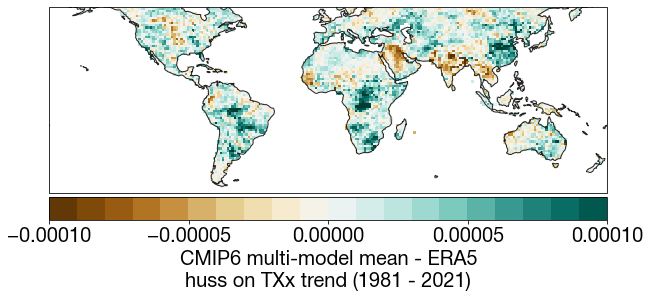

In [103]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.0001
v2 = .00011
vstep = .00001
vlabelstep = .00005

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_huss_on_txx_slope,axis=0)-era5_huss_on_txx_trend_regrid

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 multi-model mean - ERA5\nhuss on TXx trend (1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


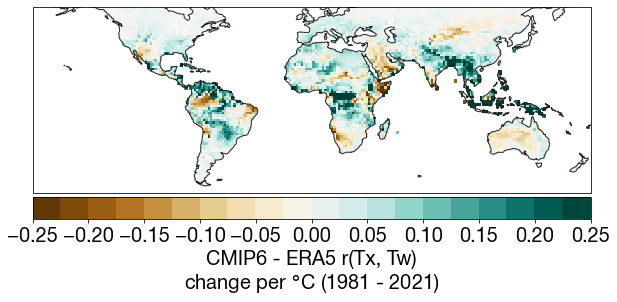

In [94]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = np.nanmean(cmip6_r_tx_tw_per_deg, axis=0)-era5_r_tx_tw_per_deg_regrid_to_cmip6

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
        
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 - ERA5 r(Tx, Tw)\nchange per $\degree$C (1981 - 2021)', fontsize=20)

# plt.savefig('t-et-chg-per-deg-C-cmip6-minus-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


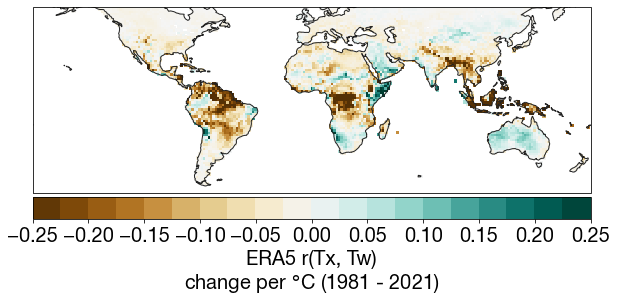

In [219]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.25
v2 = .251
vstep = .025
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = era5_r_tx_tw_per_deg_regrid_to_cmip6

c = plt.pcolormesh(cmip6_hist_corr_spatial.longitude, cmip6_hist_corr_spatial.latitude, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 r(Tx, Tw)\nchange per $\degree$C (1981 - 2021)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [163]:
# Step 1: Determine the sign of the variable
signs = np.sign(cmip6_r_tx_tw_per_deg)

# Step 2: Count the agreement on the sign for each lat-lon point
# Positive agreement count
positive_agreement = np.sum(signs == 1, axis=0)
# Negative agreement count
negative_agreement = np.sum(signs == -1, axis=0)

# Total agreement considering both positive and negative
total_agreement = np.maximum(positive_agreement, negative_agreement).astype(numpy.float32)/len(cmip6_models)

total_agreement[np.isnan(cmip6_r_tx_tw_per_deg[0,:,:])] = np.nan

In [202]:
cmip6_tx_tw_minus_tx_tx_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx)
cmip6_tw_tx_minus_tw_tw_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww)


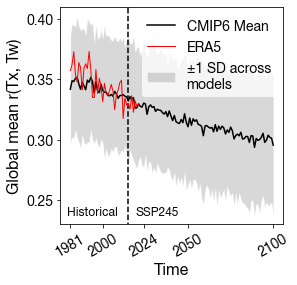

In [149]:
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation across the 'latitude', 'longitude', and 'model' dimensions
mean_vals = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial.tx_tw_corr).mean(dim='model')
std_dev = xgrid_utils.calc_spatial_mean(cmip6_hist_corr_spatial.tx_tw_corr).std(dim='model')

# Calculate the upper and lower bounds as mean ± 1 standard deviation
upper_bound = mean_vals + std_dev
lower_bound = mean_vals - std_dev

# Assuming 'time' is the dimension along which you want to plot
time = mean_vals['year']  # Adjust this if your time dimension is named differently

plt.figure(figsize=(4, 4))
plt.ylim([.23, .41])
plt.plot(time, mean_vals, label='CMIP6 Mean', color='k')
plt.plot([2015, 2015], [.22, .42], '--k')
plt.fill_between(time, lower_bound, upper_bound, color='gray', alpha=0.3, ec='white', label='±1 SD across\nmodels')
plt.plot(np.arange(1981,2021+1), tx_tw_corr_ts.tx_tw_corr, c='r', lw=1, label='ERA5')

plt.text(1994, .24, "Historical", ha='center', va='center', fontsize=12)  # Adjust coordinates and fontsize as necessary
plt.text(2032, .24, "SSP245", ha='center', va='center', fontsize=12)  # Adjust coordinates and fontsize as necessary

plt.xticks([1981, 2000, 2024, 2050, 2100], rotation=30)

plt.xlabel('Time')  # Adjust as necessary
plt.ylabel('Global mean r(Tx, Tw)')  # Adjust as necessary
l = plt.legend(fontsize=14, framealpha=.75, )
l.get_frame().set_linewidth(0)

# plt.savefig('r(tx,tw)-cmip6-hist-fut.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [195]:
# Initialize a list to store the monthly means for each ensemble member
lens_tx_tw_ensemble_members = []

n_members = 40

# Loop through ensemble members from 1-10
for i in range(1, n_members+1):
    # Load the data for the current ensemble member
    tx_tw_corr_lens = xr.open_dataset(f'tx_tw_corr_lens_member_{i}.nc')
    tx_tw_corr_lens = tx_tw_corr_lens.rename({'__xarray_dataarray_variable__': 'tw'})
    
    tx_tw_corr_lens.load()
    
    # Append the monthly mean to the list
    lens_tx_tw_ensemble_members.append(tx_tw_corr_lens)

# Concatenate along the 'ensemble' dimension
lens_tx_tw_ensemble_members = xr.concat(lens_tx_tw_ensemble_members, dim='ensemble')
lens_tx_tw_ensemble_members['ensemble'] = np.arange(1, n_members+1)  # Assign ensemble member numbers to the 'ensemble' coordinate
lens_tx_tw_ensemble_members = lens_tx_tw_ensemble_members.rename({'lat':'latitude', 'lon':'longitude'})

In [196]:
lens_tx_tw_ensemble_members_spatial_mean = xgrid_utils.calc_spatial_mean(lens_tx_tw_ensemble_members.sel(latitude=slice(-60, 60)))

In [197]:

# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    nn = np.where(~np.isnan(y))[0]
    x = np.arange(len(y))
    X = sm.add_constant(x[nn])  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y[nn], X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
lens_tx_tw_corr_slopes = []
lens_tx_tw_corr_pvals = []

for i in lens_tx_tw_ensemble_members_spatial_mean.ensemble.values:
    model_data = lens_tx_tw_ensemble_members_spatial_mean.tw.sel(ensemble=i).values
    slope, pval = calculate_ols_slope(model_data)
    lens_tx_tw_corr_slopes.append(slope*10)
    lens_tx_tw_corr_pvals.append(pval)
    
lens_tx_tw_corr_slopes = xr.DataArray(lens_tx_tw_corr_slopes, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])
lens_tx_tw_corr_pvals = xr.DataArray(lens_tx_tw_corr_pvals, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])


In [198]:
with open(f'lens_global_mean_tx.pkl', 'rb') as file:
    lens_gmt = pickle.load(file)

In [199]:
lens_gmt_slopes = []
lens_r_tx_tw_per_gmt = []

for m in range(len(lens_gmt)):
    X = sm.add_constant(range(lens_gmt[0].values.size))
    mdl = sm.OLS(lens_gmt[m].values, X).fit()
    lens_gmt_slopes.append(mdl.params[1]*10)
    lens_r_tx_tw_per_gmt.append(lens_tx_tw_corr_slopes.values[m]/lens_gmt_slopes[m])
lens_r_tx_tw_per_gmt = np.array(lens_r_tx_tw_per_gmt)

In [200]:
cmip6_gmt_slopes = []
cmip6_gmt_slope_ratio = []
for i in range(len(global_mean_tx_ts_hist)):
    #calc rate of change of gmt in each model
    X = sm.add_constant(np.arange(global_mean_tx_ts_hist[i].values.size))
    mdl = sm.OLS(global_mean_tx_ts_hist[i].values, X).fit()
    cmip6_gmt_slopes.append(mdl.params[1])
    # calc r(tx,tw) per deg c using rate of change of r(tx,tw)
    cmip6_gmt_slope_ratio.append((corr_ts_slopes[i]/10)/mdl.params[1])

In [203]:
# Calculate the spatial average for each model and time
# cmip6_tx_tw_minus_tx_tx_spatial_mean = (tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx).mean(dim=['lat', 'lon'])
# cmip6_tw_tx_minus_tw_tw_spatial_mean = (tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww).mean(dim=['lat', 'lon'])

# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    x = np.arange(len(y))
    X = sm.add_constant(x)  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y, X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
cmip6_tx_tw_minus_tx_tx_slopes = []
cmip6_tx_tw_minus_tx_tx_pvals = []

cmip6_tw_tx_minus_tw_tw_slopes = []
cmip6_tw_tx_minus_tw_tw_pvals = []

for model in cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values:
    model_data = cmip6_tx_tw_minus_tx_tx_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tx_tw_minus_tx_tx_slopes.append(slope*10)
    cmip6_tx_tw_minus_tx_tx_pvals.append(pval)
    
    model_data = cmip6_tw_tx_minus_tw_tw_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tw_tx_minus_tw_tw_slopes.append(slope*10)
    cmip6_tw_tx_minus_tw_tw_pvals.append(pval)

cmip6_tx_tw_minus_tx_tx_slopes = xr.DataArray(cmip6_tx_tw_minus_tx_tx_slopes, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])
cmip6_tx_tw_minus_tx_tx_pvals = xr.DataArray(cmip6_tx_tw_minus_tx_tx_pvals, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])

cmip6_tw_tx_minus_tw_tw_slopes = xr.DataArray(cmip6_tw_tx_minus_tw_tw_slopes, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])
cmip6_tw_tx_minus_tw_tw_pvals = xr.DataArray(cmip6_tw_tx_minus_tw_tw_pvals, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])



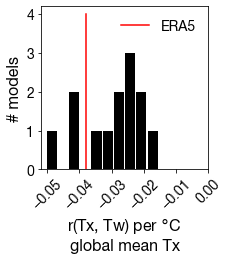

In [204]:
obs_gmt_slope_ratio = -0.038118621780981944
plt.figure(figsize=(3,3))
plt.hist(cmip6_gmt_slope_ratio, fc='black', rwidth=.9)
plt.plot([obs_gmt_slope_ratio,obs_gmt_slope_ratio], [0,4], c='red', label='ERA5')
plt.xticks([-.05, -.04, -.03, -.02, -.01, 0], rotation=45)
plt.ylabel('# models')
plt.xlabel('r(Tx, Tw) per $\degree$C\nglobal mean Tx')
l = plt.legend(fontsize=14, framealpha=.75, )
l.get_frame().set_linewidth(0)

Text(0, 0.5, 'Global mean r(Tx, Tw)\nchange per $\\degree$C\n(1981-2021)')

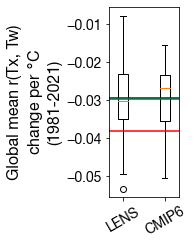

In [205]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.xlim([.5, 1.5])
plt.boxplot([lens_r_tx_tw_per_gmt, cmip6_gmt_slope_ratio], positions=[.7, 1.3])
plt.plot([.5, 1.5], [obs_gmt_slope_ratio, obs_gmt_slope_ratio], '-r', label='ERA5')
plt.plot([.5, 1.5], [np.nanmean(cmip6_gmt_slope_ratio), np.nanmean(cmip6_gmt_slope_ratio)], '-b', label='CMIP6\nmean')
plt.plot([.5, 1.5], [np.nanmean(lens_r_tx_tw_per_gmt), np.nanmean(lens_r_tx_tw_per_gmt)], '-g', label='LENS\nmean')
plt.xticks([.7,1.3], rotation=30)
plt.gca().set_xticklabels(['LENS', 'CMIP6'])
plt.ylabel('Global mean r(Tx, Tw)\nchange per $\degree$C\n(1981-2021)')
# l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# l.get_frame().set_linewidth(0)
# plt.savefig('r(tx,tw)-vs-gmt-cmip6-lens-era5-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

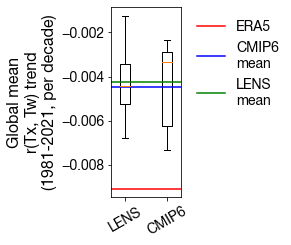

In [31]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
# plt.boxplot(1, lens_tx_tw_corr_slopes)
# plt.boxplot(2, corr_ts_slopes)
plt.boxplot([lens_tx_tw_corr_slopes, corr_ts_slopes], positions=[.7, 1.3])
plt.xlim([.5, 1.5])
plt.plot([0, 2], [obs_slope, obs_slope], '-r', label='ERA5')
plt.plot([0, 2], [np.nanmean(corr_ts_slopes), np.nanmean(corr_ts_slopes)], '-b', label='CMIP6\nmean')
plt.plot([0, 2], [np.nanmean(lens_tx_tw_corr_slopes), np.nanmean(lens_tx_tw_corr_slopes)], '-g', label='LENS\nmean')

plt.ylabel('Global mean\nr(Tx, Tw) trend\n(1981-2021, per decade)')
plt.xticks([.7, 1.3], rotation=30)
plt.gca().set_xticklabels(['LENS', 'CMIP6'])

l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

# plt.savefig('r(tx,tw)-trend-cmip6-lens-era5.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)